In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from __future__ import print_function
from pandas import *
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, subplots, imshow, xticks, yticks, title
import pickle
from scipy import stats
import copy
from scipy.stats import entropy
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics.cluster import mutual_info_score

from sklearn.cluster import KMeans

# For statistics. Requires statsmodels 5.0 or more
#from statsmodels.formula.api import ols,gls,wls
# Analysis of Variance (ANOVA) on linear models
#from statsmodels.stats.anova import anova_lm
#tutorial link: https://www.kaggle.com/kanncaa1/recurrent-neural-network-with-pytorch

(8, 5, 4) (8, 6) (3, 8, 2) (40, 3)


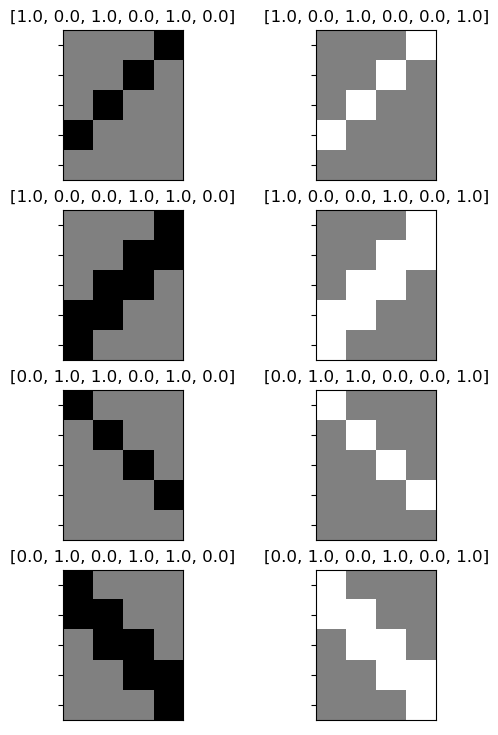

In [3]:
#make dataset
startCondition=[
    [ 0.0, 0.0, 0.0, 0.0,-1.0, 0.0],
    [ 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
    [ 0.0, 0.0, 0.0, 0.0,-1.0,-1.0],
    [ 0.0, 0.0, 0.0, 0.0, 1.0, 1.0],
    [ 0.0,-1.0, 0.0, 0.0, 0.0, 0.0],
    [ 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
    [-1.0,-1.0, 0.0, 0.0, 0.0, 0.0],
    [ 1.0, 1.0, 0.0, 0.0, 0.0, 0.0]
]
X=[]
Y=[]
worldS=[[],[],[]]
worldConcept=[]
figure(figsize=[2,8])
plt.gcf().set_size_inches(6, 10) 
for d in range(2):
    for s in range(2):
        for b in range(2):
            sequence=[]
            condInt=d*4+s*2+b
            currentCondition=startCondition[condInt]
            for steps in range(5):
                row=[0.0,0.0,0.0,0.0]
                for r in range(4):
                    row[r]=currentCondition[r+1]
                if d==0:
                    currentCondition.pop(0)
                    currentCondition.append(0.0)
                else:
                    currentCondition.pop()
                    currentCondition.insert(0,0.0)
                #print(d,s,b,steps,row)
                sequence.append(row)
                worldConcept.append([d,s,b])
            subplot(4,2,condInt+1)
            X.append(copy.deepcopy(sequence))
            answer=[0.0,0.0,0.0,0.0,0.0,0.0]
            answer[d]=1.0
            answer[s+2]=1.0
            answer[b+4]=1.0
            Y.append(answer)
            imshow(sequence,cmap="gray",vmin=-1.0,vmax=1.0)
            #ylim(-0.5,7.5)
            xticks([],[])
            yticks(range(5),[""]*5)
            subplots_adjust(top=0.8)
            title(answer)
            subAd=[0.0,0.0]
            subAd[d]=1.0
            subAs=[0.0,0.0]
            subAs[s]=1.0
            subAb=[0.0,0.0]
            subAb[b]=1.0
            worldS[0].append(subAd)
            worldS[1].append(subAs)
            worldS[2].append(subAb)
    #tight_layout()
X=numpy.array(X)
Y=numpy.array(Y)
worldS=numpy.array(worldS)
worldConcept=numpy.array(worldConcept)
print(X.shape,Y.shape,worldS.shape,worldConcept.shape)

In [4]:
def makeNoisyDataset(X,Y,replicatesPerItem,noise,randomize=True,delayRange=[3]):
    nX=[]
    nY=[]
    nW=[]
    wc=[[0,0,0],[0,0,1],[0,1,0],[0,1,1],[1,0,0],[1,0,1],[1,1,0],[1,1,1]]
    for n in range(8):
        for i in range(replicatesPerItem):
            dr=numpy.random.choice(delayRange)
            M=numpy.concatenate((X[n],numpy.zeros((int(dr),4))))
            nX.append(M+numpy.random.normal(0.0,noise,(M.shape)))
            nY.append(Y[n])
            nW.append(wc[n])
    #nX=numpy.array(nX)
    nX=numpy.array(nX, dtype=object)
    nY=numpy.array(nY)
    nW=numpy.array(nW)
    if randomize:
        m=8*replicatesPerItem
        order=numpy.random.choice(list(range(m)),(m),replace=False)
        nX=nX[order]
        nY=nY[order]
        nW=nW[numpy.repeat(order,8)]
    nS=[]
    nS.append(nY.transpose()[0:2].transpose())
    nS.append(nY.transpose()[2:4].transpose())
    nS.append(nY.transpose()[4:6].transpose())
    nS=numpy.array(nS)
    return nX,nY,nS,nW 
nX,nY,nS,nW=makeNoisyDataset(X,Y,8,0.2,delayRange=[1,5])
#h=hist(nX.flatten(),linspace(-1.5,1.5,101))
print(nX.shape,nY.shape,nS.shape,nW.shape)

(64,) (64, 6) (3, 64, 2) (512, 3)


In [5]:
def makeNoisyDataset(X,Y,replicatesPerItem,noise,randomize=True,delayRange=[3]):
    nX=[]
    nY=[]
    nW=[]
    wc=[[0,0,0],[0,0,1],[0,1,0],[0,1,1],[1,0,0],[1,0,1],[1,1,0],[1,1,1]]
    for n in range(8):
        for i in range(replicatesPerItem):
            dr=numpy.random.choice(delayRange)
            M=numpy.concatenate((X[n],numpy.zeros((int(dr),4))))
            nX.append(M+numpy.random.normal(0.0,noise,(M.shape)).astype(numpy.float32)) #explicit cast to numpy.float32
            nY.append(Y[n].astype(numpy.float32))
            nW.append(wc[n])
    nX=numpy.array(nX)
    nY=numpy.array(nY)
    nW=numpy.array(nW)
    if randomize:
        m=8*replicatesPerItem
        order=numpy.random.choice(list(range(m)),(m),replace=False)
        nX=nX[order]
        nY=nY[order]
        nW=nW[numpy.repeat(order,8)]
    nS=[]
    nS.append(nY.transpose()[0:2].transpose())
    nS.append(nY.transpose()[2:4].transpose())
    nS.append(nY.transpose()[4:6].transpose())
    nS=numpy.array(nS)
    return nX,nY,nS,nW 
nX,nY,nS,nW=makeNoisyDataset(X,Y,8,0.2,delayRange=[1,5])
print(nX.shape,nY.shape,nS.shape,nW.shape)

(64,) (64, 6) (3, 64, 2) (512, 3)


C:\Users\enajasa\AppData\Local\Temp\ipykernel_7964\1205567648.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  nX=numpy.array(nX)


In [6]:
class Net(nn.Module):
    def __init__(self,hidden_dim=12,output_dim=6):
        super(Net, self).__init__()
        self.rnnLayer=nn.RNN(4,hidden_dim,batch_first=True)
        self.outputLayer=nn.Linear(hidden_dim,output_dim)
        self.hidden_dim=hidden_dim
        self.resetHidden()
        
    def resetHidden(self):
        self.hidden=list()
        
    def forward(self, x,return_activations=False):
        self.h0=torch.Tensor(numpy.zeros((1,x.shape[0],self.hidden_dim)))
        out,self.h0=self.rnnLayer(x,self.h0)
        out=torch.tanh(out)
        self.hidden.append(copy.deepcopy(self.h0.detach().numpy()))
        out=torch.sigmoid(self.outputLayer(out[:, -1, :]))
        if return_activations:
            activations = out.detach().numpy()
            return out, activations
        return out
    

    
    def step(self,x):
        O=[]
        H=[]
        for l in range(x.shape[0]):
            h0=torch.Tensor(numpy.zeros((1,1,self.hidden_dim)))
            for i in range(x.shape[1]):
                out,h0=self.rnnLayer(x[l][i].reshape((1,1,4)),h0)
                H.append(out.detach().numpy().flatten())
            out=torch.tanh(out)
            out=torch.sigmoid(self.outputLayer(out[:, -1, :]))
            for i in range(x.shape[1]):
                O.append(out.detach().numpy().flatten())
        return numpy.array(O),numpy.array(H)
    
model=Net()

    

In [7]:
def test (model,X=X,Y=Y,S=worldS):
    divs=[]
    for i in range(X.shape[0]):
        model.resetHidden()
        output=model(torch.Tensor(X[i].reshape(1,X[i].shape[0],4)))
        div=output.detach().numpy().reshape(Y[i].shape)-Y[i]
        divs.append(1.0-abs(div).mean())
    acc=mean(divs)
    return acc

model=Net(hidden_dim=12,output_dim=6)
#model.load_state_dict(torch.load("fullModel.model"))
print("full model:",test(model))

full model: 0.4997050681461891


In [27]:
import matplotlib.pyplot as plt


num_replicates = 10
cdrmodels = {}

#for delayRange in delay_ranges:
#    print(f"Training for delay range {delayRange}...")
all_w = []

for replicate in range(num_replicates):
    model=Net(hidden_dim=12,output_dim=6)
    optimizer = optim.Adam(model.parameters(),lr=0.001)
    error = nn.MSELoss()
    acc=0.0
    W=[]
    Ts=[]
    iteration_list = []
    loss_list = []
    accuracy_list = []

    while acc<0.97:
        divs=[]
        model.resetHidden()
        nX,nY,nS,nW=makeNoisyDataset(X,Y,8,0.2,delayRange=[1,2,3,4,5]) #variance for the ND is 0.2
        for i in range(nX.shape[0]): #use 64 when training for single delayRange
            optimizer.zero_grad()
            output = model(torch.Tensor(nX[i].reshape(1,nX[i].shape[0],4))) #shape greater than 8
            loss = error(output, torch.Tensor(nY[i]))
            loss.backward()
            optimizer.step()
            div=output.detach().numpy().reshape(nY[i].shape)-nY[i]
            divs.append(1.0-abs(div).mean())
            current_iteration = len(iteration_list) + 1
            loss_list.append(loss.item())
            iteration_list.append(current_iteration)
            accuracy_list.append(mean(divs))

        acc=mean(divs)
        W.append(acc)
        #total, subA, antiA = test(model, X=nX, Y=nY, S=nS)
        total = test(model, X=nX, Y=nY, S=nS)
        #Ts.append(subA)
        print(f"Iteration: {current_iteration}, Loss: {loss.item()}, Accuracy: {accuracy_list[-1]}")

    model_name = f"CDRfullModel_dr_replicate{replicate}.model"
    torch.save(model.state_dict(), model_name)
    print(f"Saved {model_name}")
    cdrmodels[model_name] = model

    W_name = f"W_dr_replicate{replicate}.p"
    with open(W_name, "wb") as f:
        pickle.dump(W, f)
    print(f"Saved {W_name}")

    w=[]
    for tr in [0,1,2,3,4,5,6,7]:
        nX,nY,nS,nW=makeNoisyDataset(X,Y,8,0.2,delayRange=[tr])
        #total, subA, antiA = test(model, X=nX, Y=nY, S=nS)
        total = test(model, X=nX, Y=nY, S=nS)
        print(tr,total)
        w.append(total)

    all_w.append(w)
    w_name = f"w_dr_replicate{replicate}.p"
    with open(w_name, "wb") as f:
        pickle.dump(w, f)
    print(f"Saved {w_name}")

    print(f"Replicate {replicate} completed")
    print(f"Time elapsed: {time.process_time()} seconds")


C:\Users\enajasa\AppData\Local\Temp\ipykernel_7964\1205567648.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  nX=numpy.array(nX)
C:\Users\enajasa\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([1, 6])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Iteration: 64, Loss: 0.24527700245380402, Accuracy: 0.5011220499873161
Iteration: 128, Loss: 0.22608934342861176, Accuracy: 0.5055851629003882
Iteration: 192, Loss: 0.17016714811325073, Accuracy: 0.5506848860532045
Iteration: 256, Loss: 0.19894938170909882, Accuracy: 0.5933434176258743
Iteration: 320, Loss: 0.19741779565811157, Accuracy: 0.6127558122389019
Iteration: 384, Loss: 0.19651885330677032, Accuracy: 0.6230985494330525
Iteration: 448, Loss: 0.19623132050037384, Accuracy: 0.63007582584396
Iteration: 512, Loss: 0.18521402776241302, Accuracy: 0.6331062698736787
Iteration: 576, Loss: 0.16968566179275513, Accuracy: 0.6333855292759836
Iteration: 640, Loss: 0.15890580415725708, Accuracy: 0.6404877169989049
Iteration: 704, Loss: 0.1583641618490219, Accuracy: 0.6428169566206634
Iteration: 768, Loss: 0.1535656899213791, Accuracy: 0.6445137523114681
Iteration: 832, Loss: 0.1866678148508072, Accuracy: 0.6462670927867293
Iteration: 896, Loss: 0.18383820354938507, Accuracy: 0.646800037939101

Iteration: 7296, Loss: 0.18797904253005981, Accuracy: 0.6956861342769116
Iteration: 7360, Loss: 0.18499530851840973, Accuracy: 0.6901774741709232
Iteration: 7424, Loss: 0.14924326539039612, Accuracy: 0.6972845080308616
Iteration: 7488, Loss: 0.1914040446281433, Accuracy: 0.6987498386297375
Iteration: 7552, Loss: 0.11000829935073853, Accuracy: 0.6970983101055026
Iteration: 7616, Loss: 0.15123751759529114, Accuracy: 0.6983002002816647
Iteration: 7680, Loss: 0.1879393309354782, Accuracy: 0.706408680183813
Iteration: 7744, Loss: 0.19018162786960602, Accuracy: 0.7035468723624945
Iteration: 7808, Loss: 0.10975035279989243, Accuracy: 0.6948921289294958
Iteration: 7872, Loss: 0.0946827158331871, Accuracy: 0.6963070274796337
Iteration: 7936, Loss: 0.1092751994729042, Accuracy: 0.7008546029683203
Iteration: 8000, Loss: 0.10646381229162216, Accuracy: 0.7047239353414625
Iteration: 8064, Loss: 0.11001869291067123, Accuracy: 0.7029733518138528
Iteration: 8128, Loss: 0.15221238136291504, Accuracy: 0.

Iteration: 14464, Loss: 0.093319833278656, Accuracy: 0.7602902397047728
Iteration: 14528, Loss: 0.11495381593704224, Accuracy: 0.7642762921750546
Iteration: 14592, Loss: 0.08253763616085052, Accuracy: 0.7639785904902965
Iteration: 14656, Loss: 0.09153721481561661, Accuracy: 0.780779862543568
Iteration: 14720, Loss: 0.08703207224607468, Accuracy: 0.7712285073939711
Iteration: 14784, Loss: 0.08652296662330627, Accuracy: 0.7725961175747216
Iteration: 14848, Loss: 0.13296076655387878, Accuracy: 0.7683907891623676
Iteration: 14912, Loss: 0.1490105241537094, Accuracy: 0.7598959226161242
Iteration: 14976, Loss: 0.09639360755681992, Accuracy: 0.7712369945365936
Iteration: 15040, Loss: 0.08846652507781982, Accuracy: 0.7828577414620668
Iteration: 15104, Loss: 0.09664418548345566, Accuracy: 0.7541236523538828
Iteration: 15168, Loss: 0.09386438131332397, Accuracy: 0.7723588058724999
Iteration: 15232, Loss: 0.08476939797401428, Accuracy: 0.780162540730089
Iteration: 15296, Loss: 0.08803752809762955

Iteration: 21696, Loss: 0.08430231362581253, Accuracy: 0.7863003669772297
Iteration: 21760, Loss: 0.087290458381176, Accuracy: 0.8009048462845385
Iteration: 21824, Loss: 0.08551954478025436, Accuracy: 0.803124544210732
Iteration: 21888, Loss: 0.08771277219057083, Accuracy: 0.8142096782103181
Iteration: 21952, Loss: 0.11641844362020493, Accuracy: 0.8160617949906737
Iteration: 22016, Loss: 0.0862569585442543, Accuracy: 0.816750914324075
Iteration: 22080, Loss: 0.08967144042253494, Accuracy: 0.8112500482238829
Iteration: 22144, Loss: 0.08268227428197861, Accuracy: 0.7626552367582917
Iteration: 22208, Loss: 0.08398272842168808, Accuracy: 0.7820724893826991
Iteration: 22272, Loss: 0.08151330798864365, Accuracy: 0.7948154571931809
Iteration: 22336, Loss: 0.10389169305562973, Accuracy: 0.7988021541386843
Iteration: 22400, Loss: 0.0867842361330986, Accuracy: 0.8024681925307959
Iteration: 22464, Loss: 0.08584734797477722, Accuracy: 0.8107250728644431
Iteration: 22528, Loss: 0.08210606127977371,

Iteration: 28992, Loss: 0.08179726451635361, Accuracy: 0.8229884256143123
Iteration: 29056, Loss: 0.08629462122917175, Accuracy: 0.8206980403047055
Iteration: 29120, Loss: 0.08073901385068893, Accuracy: 0.8233116816263646
Iteration: 29184, Loss: 0.08090749382972717, Accuracy: 0.8078329148702323
Iteration: 29248, Loss: 0.08278951793909073, Accuracy: 0.8188113537617028
Iteration: 29312, Loss: 0.09404465556144714, Accuracy: 0.8221956274937838
Iteration: 29376, Loss: 0.0742332860827446, Accuracy: 0.8072345717810094
Iteration: 29440, Loss: 0.3949418365955353, Accuracy: 0.7948000386822969
Iteration: 29504, Loss: 0.08157812803983688, Accuracy: 0.7849346722941846
Iteration: 29568, Loss: 0.08685194700956345, Accuracy: 0.8095137944910675
Iteration: 29632, Loss: 0.08909804373979568, Accuracy: 0.8202598213683814
Iteration: 29696, Loss: 0.07583921402692795, Accuracy: 0.8193113666493446
Iteration: 29760, Loss: 0.11088716983795166, Accuracy: 0.8131881037261337
Iteration: 29824, Loss: 0.08663614839315

Iteration: 36288, Loss: 0.07705963402986526, Accuracy: 0.8173972347285599
Iteration: 36352, Loss: 0.06382114440202713, Accuracy: 0.8047449423465878
Iteration: 36416, Loss: 0.1270139217376709, Accuracy: 0.8217537710443139
Iteration: 36480, Loss: 0.08347418904304504, Accuracy: 0.8061712333001196
Iteration: 36544, Loss: 0.0965408980846405, Accuracy: 0.8272474438417703
Iteration: 36608, Loss: 0.07746835798025131, Accuracy: 0.8252785985823721
Iteration: 36672, Loss: 0.07967405021190643, Accuracy: 0.8253034767694771
Iteration: 36736, Loss: 0.11356279253959656, Accuracy: 0.8273780315648764
Iteration: 36800, Loss: 0.10673386603593826, Accuracy: 0.8187114098109305
Iteration: 36864, Loss: 0.07350267469882965, Accuracy: 0.8261666951002553
Iteration: 36928, Loss: 0.0746249184012413, Accuracy: 0.8273744585458189
Iteration: 36992, Loss: 0.08901235461235046, Accuracy: 0.8270409790566191
Iteration: 37056, Loss: 0.0793222114443779, Accuracy: 0.8298093675402924
Iteration: 37120, Loss: 0.0586957521736621

Iteration: 43520, Loss: 0.12219343334436417, Accuracy: 0.8375850798329338
Iteration: 43584, Loss: 0.07501128315925598, Accuracy: 0.8392892582342029
Iteration: 43648, Loss: 0.02923833392560482, Accuracy: 0.8438762502046302
Iteration: 43712, Loss: 0.09860438108444214, Accuracy: 0.8393655580002815
Iteration: 43776, Loss: 0.012605231255292892, Accuracy: 0.8244029440684244
Iteration: 43840, Loss: 0.047442514449357986, Accuracy: 0.8418068796163425
Iteration: 43904, Loss: 0.09583249688148499, Accuracy: 0.8446250380948186
Iteration: 43968, Loss: 0.13097713887691498, Accuracy: 0.8465127818053588
Iteration: 44032, Loss: 0.07330995053052902, Accuracy: 0.840441407286562
Iteration: 44096, Loss: 0.10472125560045242, Accuracy: 0.8456719608511776
Iteration: 44160, Loss: 0.05125238001346588, Accuracy: 0.8473010633606464
Iteration: 44224, Loss: 0.13102632761001587, Accuracy: 0.8436811758438125
Iteration: 44288, Loss: 0.04032079502940178, Accuracy: 0.8403598075965419
Iteration: 44352, Loss: 0.11086079478

Iteration: 50752, Loss: 0.02429017424583435, Accuracy: 0.9060821851307992
Iteration: 50816, Loss: 0.020551415160298347, Accuracy: 0.9078948938840767
Iteration: 50880, Loss: 0.0009139656904153526, Accuracy: 0.921230944499257
Iteration: 50944, Loss: 0.007386279758065939, Accuracy: 0.9201375924312742
Iteration: 51008, Loss: 0.001579487114213407, Accuracy: 0.9203846210439224
Iteration: 51072, Loss: 0.018278853967785835, Accuracy: 0.9280359899566974
Iteration: 51136, Loss: 0.00475087808445096, Accuracy: 0.9233729098050389
Iteration: 51200, Loss: 0.020816272124648094, Accuracy: 0.9087125131482026
Iteration: 51264, Loss: 0.009063460864126682, Accuracy: 0.9227872229093919
Iteration: 51328, Loss: 0.02915436029434204, Accuracy: 0.9313599171873648
Iteration: 51392, Loss: 0.0014864512486383319, Accuracy: 0.9198620533861686
Iteration: 51456, Loss: 0.0003120334295090288, Accuracy: 0.9371523108420661
Iteration: 51520, Loss: 0.011674442328512669, Accuracy: 0.9283256406488363
Iteration: 51584, Loss: 0.

Iteration: 57728, Loss: 0.0005385389667935669, Accuracy: 0.9563459027122008
Iteration: 57792, Loss: 0.0005383433308452368, Accuracy: 0.9629910763324006
Iteration: 57856, Loss: 9.429587953491136e-05, Accuracy: 0.9570347160333768
Iteration: 57920, Loss: 0.003285530023276806, Accuracy: 0.965534522481903
Iteration: 57984, Loss: 0.007319889962673187, Accuracy: 0.9648490919062169
Iteration: 58048, Loss: 0.002664929023012519, Accuracy: 0.9628018025323399
Iteration: 58112, Loss: 0.0009156014421023428, Accuracy: 0.9699885428708512
Iteration: 58176, Loss: 0.000914979784283787, Accuracy: 0.9614383571170038
Iteration: 58240, Loss: 0.002363472478464246, Accuracy: 0.9613551520524197
Iteration: 58304, Loss: 0.0032248308416455984, Accuracy: 0.9677015007473528
Iteration: 58368, Loss: 0.00036062905564904213, Accuracy: 0.9664635234148591
Iteration: 58432, Loss: 5.6370929087279364e-05, Accuracy: 0.9584757711490965
Iteration: 58496, Loss: 0.000572876597288996, Accuracy: 0.9564443381750607
Iteration: 58560,

Iteration: 6272, Loss: 0.0985463336110115, Accuracy: 0.7709746651817113
Iteration: 6336, Loss: 0.07595689594745636, Accuracy: 0.7869769141543657
Iteration: 6400, Loss: 0.27138933539390564, Accuracy: 0.7793421244714409
Iteration: 6464, Loss: 0.07229330390691757, Accuracy: 0.7814100002869964
Iteration: 6528, Loss: 0.07917973399162292, Accuracy: 0.7852466767653823
Iteration: 6592, Loss: 0.0884542167186737, Accuracy: 0.7707639466971159
Iteration: 6656, Loss: 0.08443493396043777, Accuracy: 0.7868018762674183
Iteration: 6720, Loss: 0.07676981389522552, Accuracy: 0.793897497933358
Iteration: 6784, Loss: 0.0987342894077301, Accuracy: 0.780781410401687
Iteration: 6848, Loss: 0.08223416656255722, Accuracy: 0.7811692629475147
Iteration: 6912, Loss: 0.1376480907201767, Accuracy: 0.7857006010599434
Iteration: 6976, Loss: 0.07319096475839615, Accuracy: 0.7880670230370015
Iteration: 7040, Loss: 0.07539284974336624, Accuracy: 0.7966926980298012
Iteration: 7104, Loss: 0.076837919652462, Accuracy: 0.773

Iteration: 13504, Loss: 0.10352904349565506, Accuracy: 0.8142749845283106
Iteration: 13568, Loss: 0.10002955794334412, Accuracy: 0.8243977518286556
Iteration: 13632, Loss: 0.027112456038594246, Accuracy: 0.8203135515796021
Iteration: 13696, Loss: 0.02228737436234951, Accuracy: 0.8177939429879189
Iteration: 13760, Loss: 0.09830231219530106, Accuracy: 0.8177487064385787
Iteration: 13824, Loss: 0.014388389885425568, Accuracy: 0.8284381732810289
Iteration: 13888, Loss: 0.06902164965867996, Accuracy: 0.8170448798919097
Iteration: 13952, Loss: 0.02404785342514515, Accuracy: 0.8416901602176949
Iteration: 14016, Loss: 0.17701391875743866, Accuracy: 0.8308489219052717
Iteration: 14080, Loss: 0.2458149939775467, Accuracy: 0.831057068775408
Iteration: 14144, Loss: 0.07489276677370071, Accuracy: 0.8171915616840124
Iteration: 14208, Loss: 0.10093653947114944, Accuracy: 0.7997384004993364
Iteration: 14272, Loss: 0.10717570036649704, Accuracy: 0.818966637714766
Iteration: 14336, Loss: 0.0144907487556

Iteration: 20608, Loss: 0.008568565361201763, Accuracy: 0.8764343947987072
Iteration: 20672, Loss: 0.2867182195186615, Accuracy: 0.8595027329283766
Iteration: 20736, Loss: 0.00781718734651804, Accuracy: 0.8582373913377523
Iteration: 20800, Loss: 0.08488636463880539, Accuracy: 0.8364857055130415
Iteration: 20864, Loss: 0.007228003814816475, Accuracy: 0.8408214283408597
Iteration: 20928, Loss: 0.007841301150619984, Accuracy: 0.8326058366219513
Iteration: 20992, Loss: 0.0029163493309170008, Accuracy: 0.8640099376207218
Iteration: 21056, Loss: 0.05667547509074211, Accuracy: 0.8681003667297773
Iteration: 21120, Loss: 0.062132660299539566, Accuracy: 0.8578133555711247
Iteration: 21184, Loss: 0.016011441126465797, Accuracy: 0.8609168701805174
Iteration: 21248, Loss: 0.08077871054410934, Accuracy: 0.8483895637327805
Iteration: 21312, Loss: 0.07460696250200272, Accuracy: 0.859259309945628
Iteration: 21376, Loss: 0.02586730569601059, Accuracy: 0.8576925966190174
Iteration: 21440, Loss: 0.0031940

Iteration: 27712, Loss: 0.004737424198538065, Accuracy: 0.8768113062251359
Iteration: 27776, Loss: 0.011727082543075085, Accuracy: 0.8781978597689886
Iteration: 27840, Loss: 0.06140429899096489, Accuracy: 0.8863184870278928
Iteration: 27904, Loss: 0.08692847937345505, Accuracy: 0.8794154117349535
Iteration: 27968, Loss: 0.11517149955034256, Accuracy: 0.8891389417112805
Iteration: 28032, Loss: 0.002475696848705411, Accuracy: 0.8814903799211606
Iteration: 28096, Loss: 0.07296403497457504, Accuracy: 0.8768684309034143
Iteration: 28160, Loss: 0.0011600996367633343, Accuracy: 0.8821945459058043
Iteration: 28224, Loss: 0.0013993332395330071, Accuracy: 0.874301963893231
Iteration: 28288, Loss: 0.005502436775714159, Accuracy: 0.887782231962774
Iteration: 28352, Loss: 0.04224696755409241, Accuracy: 0.8887727147666737
Iteration: 28416, Loss: 0.042555078864097595, Accuracy: 0.891696924547432
Iteration: 28480, Loss: 0.002677127020433545, Accuracy: 0.883408690802753
Iteration: 28544, Loss: 0.066575

Iteration: 34752, Loss: 0.004717947915196419, Accuracy: 0.9349104405409889
Iteration: 34816, Loss: 0.00593721866607666, Accuracy: 0.9269352223418537
Iteration: 34880, Loss: 0.004329914692789316, Accuracy: 0.9258697914556251
Iteration: 34944, Loss: 0.01883162185549736, Accuracy: 0.927199705678504
Iteration: 35008, Loss: 0.005608004052191973, Accuracy: 0.9218559522705618
Iteration: 35072, Loss: 0.049825284630060196, Accuracy: 0.9097514710883843
Iteration: 35136, Loss: 0.009690577164292336, Accuracy: 0.9198948677803855
Iteration: 35200, Loss: 0.00953871663659811, Accuracy: 0.9280662484379718
Iteration: 35264, Loss: 0.0007640354451723397, Accuracy: 0.9448775958444458
Iteration: 35328, Loss: 0.0009902550373226404, Accuracy: 0.9385821110772667
Iteration: 35392, Loss: 0.0008940762490965426, Accuracy: 0.9315087053619209
Iteration: 35456, Loss: 0.028604166582226753, Accuracy: 0.923627260424837
Iteration: 35520, Loss: 0.0020562228746712208, Accuracy: 0.9405236305319704
Iteration: 35584, Loss: 0.

Iteration: 1536, Loss: 0.1617681235074997, Accuracy: 0.6542880441993475
Iteration: 1600, Loss: 0.1645546704530716, Accuracy: 0.6549895508214831
Iteration: 1664, Loss: 0.17206180095672607, Accuracy: 0.6551760034635663
Iteration: 1728, Loss: 0.1718125343322754, Accuracy: 0.6556359864771366
Iteration: 1792, Loss: 0.17332899570465088, Accuracy: 0.6554786544293165
Iteration: 1856, Loss: 0.16958512365818024, Accuracy: 0.6563129178248346
Iteration: 1920, Loss: 0.1769028753042221, Accuracy: 0.6570149278268218
Iteration: 1984, Loss: 0.17730747163295746, Accuracy: 0.6568744638934731
Iteration: 2048, Loss: 0.16700421273708344, Accuracy: 0.6570864268578589
Iteration: 2112, Loss: 0.17071913182735443, Accuracy: 0.6574934627860785
Iteration: 2176, Loss: 0.17164713144302368, Accuracy: 0.6574119557626545
Iteration: 2240, Loss: 0.16424697637557983, Accuracy: 0.6558596892282367
Iteration: 2304, Loss: 0.16330386698246002, Accuracy: 0.6588126122951508
Iteration: 2368, Loss: 0.1728401780128479, Accuracy: 0.

Iteration: 8832, Loss: 0.1408746838569641, Accuracy: 0.7165757596958429
Iteration: 8896, Loss: 0.18519137799739838, Accuracy: 0.7192603489384055
Iteration: 8960, Loss: 0.08272311091423035, Accuracy: 0.7197586500551552
Iteration: 9024, Loss: 0.08159195631742477, Accuracy: 0.7182675218209624
Iteration: 9088, Loss: 0.3048127591609955, Accuracy: 0.7159192864783108
Iteration: 9152, Loss: 0.19196151196956635, Accuracy: 0.7222809416707605
Iteration: 9216, Loss: 0.15596036612987518, Accuracy: 0.7177598970010877
Iteration: 9280, Loss: 0.09128578752279282, Accuracy: 0.720096550649032
Iteration: 9344, Loss: 0.13277985155582428, Accuracy: 0.7272011591121554
Iteration: 9408, Loss: 0.14063142240047455, Accuracy: 0.7281907785218209
Iteration: 9472, Loss: 0.11849860101938248, Accuracy: 0.7191323153674603
Iteration: 9536, Loss: 0.09490004926919937, Accuracy: 0.729480943409726
Iteration: 9600, Loss: 0.12190843373537064, Accuracy: 0.7181097990833223
Iteration: 9664, Loss: 0.09235969930887222, Accuracy: 0

Iteration: 16128, Loss: 0.08249188959598541, Accuracy: 0.8124555354006588
Iteration: 16192, Loss: 0.09672850370407104, Accuracy: 0.8132758014835417
Iteration: 16256, Loss: 0.08942195028066635, Accuracy: 0.8129616070073098
Iteration: 16320, Loss: 0.08937662094831467, Accuracy: 0.8073216627817601
Iteration: 16384, Loss: 0.07128366827964783, Accuracy: 0.8075977673288435
Iteration: 16448, Loss: 0.08364444971084595, Accuracy: 0.8140667148400098
Iteration: 16512, Loss: 0.07436562329530716, Accuracy: 0.8139145616441965
Iteration: 16576, Loss: 0.07319539040327072, Accuracy: 0.8169431844726205
Iteration: 16640, Loss: 0.09872768074274063, Accuracy: 0.8144224034622312
Iteration: 16704, Loss: 0.09921303391456604, Accuracy: 0.819667300907895
Iteration: 16768, Loss: 0.07850918173789978, Accuracy: 0.8177764192223549
Iteration: 16832, Loss: 0.08004409819841385, Accuracy: 0.8181310608051717
Iteration: 16896, Loss: 0.0767006203532219, Accuracy: 0.8173873282503337
Iteration: 16960, Loss: 0.08016753941774

Iteration: 23360, Loss: 0.08107361197471619, Accuracy: 0.8257777318358421
Iteration: 23424, Loss: 0.079472117125988, Accuracy: 0.8258475151378661
Iteration: 23488, Loss: 0.08473286777734756, Accuracy: 0.8242049994878471
Iteration: 23552, Loss: 0.09210727363824844, Accuracy: 0.8259869164321572
Iteration: 23616, Loss: 0.09375035762786865, Accuracy: 0.8238226096145809
Iteration: 23680, Loss: 0.07490506768226624, Accuracy: 0.8256582082249224
Iteration: 23744, Loss: 0.08341193199157715, Accuracy: 0.8271787480916828
Iteration: 23808, Loss: 0.08456629514694214, Accuracy: 0.8260269057936966
Iteration: 23872, Loss: 0.08990643173456192, Accuracy: 0.8212898215278983
Iteration: 23936, Loss: 0.08725985139608383, Accuracy: 0.8154318642336875
Iteration: 24000, Loss: 0.07914303988218307, Accuracy: 0.8180514837149531
Iteration: 24064, Loss: 0.08399009704589844, Accuracy: 0.8256729836575687
Iteration: 24128, Loss: 0.08616706728935242, Accuracy: 0.8224169421009719
Iteration: 24192, Loss: 0.07468325644731

Iteration: 30464, Loss: 0.036314863711595535, Accuracy: 0.8376306733116508
Iteration: 30528, Loss: 0.07304789125919342, Accuracy: 0.8269169662380591
Iteration: 30592, Loss: 0.21919769048690796, Accuracy: 0.8269595662131906
Iteration: 30656, Loss: 0.13149569928646088, Accuracy: 0.8246560827828944
Iteration: 30720, Loss: 0.04181613028049469, Accuracy: 0.8396058167563751
Iteration: 30784, Loss: 0.0913577601313591, Accuracy: 0.8343013591365889
Iteration: 30848, Loss: 0.035943787544965744, Accuracy: 0.835480562527664
Iteration: 30912, Loss: 0.2757848799228668, Accuracy: 0.8228848951403052
Iteration: 30976, Loss: 0.11502435803413391, Accuracy: 0.8323651803657413
Iteration: 31040, Loss: 0.11550698429346085, Accuracy: 0.8347427083645016
Iteration: 31104, Loss: 0.08984824270009995, Accuracy: 0.8240183100569993
Iteration: 31168, Loss: 0.11512497812509537, Accuracy: 0.8329468470765278
Iteration: 31232, Loss: 0.0950222983956337, Accuracy: 0.8350448559504002
Iteration: 31296, Loss: 0.16306261718273

Iteration: 37696, Loss: 0.013985955156385899, Accuracy: 0.8773228022619151
Iteration: 37760, Loss: 0.28145238757133484, Accuracy: 0.8810950422775932
Iteration: 37824, Loss: 0.06331364065408707, Accuracy: 0.8872780608944595
Iteration: 37888, Loss: 0.030137300491333008, Accuracy: 0.8860235085594468
Iteration: 37952, Loss: 0.007921416312456131, Accuracy: 0.8749210325186141
Iteration: 38016, Loss: 0.024324364960193634, Accuracy: 0.8854325984721072
Iteration: 38080, Loss: 0.013418026268482208, Accuracy: 0.8765037209959701
Iteration: 38144, Loss: 0.012467022985219955, Accuracy: 0.8868997015524656
Iteration: 38208, Loss: 0.058301329612731934, Accuracy: 0.8839426457998343
Iteration: 38272, Loss: 0.05859113112092018, Accuracy: 0.8849135948112234
Iteration: 38336, Loss: 0.0064137778244912624, Accuracy: 0.8776650442159735
Iteration: 38400, Loss: 0.003896858310326934, Accuracy: 0.8923434106400236
Iteration: 38464, Loss: 0.008898166939616203, Accuracy: 0.8892972108442336
Iteration: 38528, Loss: 0.0

Iteration: 44800, Loss: 0.16132764518260956, Accuracy: 0.907664382350049
Iteration: 44864, Loss: 0.027831142768263817, Accuracy: 0.9112864077906124
Iteration: 44928, Loss: 0.0030639879405498505, Accuracy: 0.9183752164390171
Iteration: 44992, Loss: 0.08454251289367676, Accuracy: 0.9160191179107642
Iteration: 45056, Loss: 0.004475864116102457, Accuracy: 0.9099550191604067
Iteration: 45120, Loss: 0.000568173301871866, Accuracy: 0.914799515507184
Iteration: 45184, Loss: 0.10020739585161209, Accuracy: 0.9154570612736279
Iteration: 45248, Loss: 0.0005188098293729126, Accuracy: 0.9117452727514319
Iteration: 45312, Loss: 0.0008135809912346303, Accuracy: 0.9200418316177092
Iteration: 45376, Loss: 0.00016097996558528394, Accuracy: 0.9104203510214575
Iteration: 45440, Loss: 0.0008492768392898142, Accuracy: 0.9218151793902507
Iteration: 45504, Loss: 0.06933415681123734, Accuracy: 0.9210691531479824
Iteration: 45568, Loss: 0.0028797548729926348, Accuracy: 0.9200174930738285
Iteration: 45632, Loss: 

Iteration: 51840, Loss: 0.00014735404693055898, Accuracy: 0.9447999054391403
Iteration: 51904, Loss: 0.012131892144680023, Accuracy: 0.9493681696403655
Iteration: 51968, Loss: 0.002605883404612541, Accuracy: 0.943629325942311
Iteration: 52032, Loss: 0.0013979385839775205, Accuracy: 0.9402267843979644
Iteration: 52096, Loss: 0.0001950380246853456, Accuracy: 0.9347885586612392
Iteration: 52160, Loss: 0.003490491071715951, Accuracy: 0.9436063753673807
Iteration: 52224, Loss: 0.045195091515779495, Accuracy: 0.9494989602535497
Iteration: 52288, Loss: 0.0006396263488568366, Accuracy: 0.9441979031471419
Iteration: 52352, Loss: 0.0001109074437408708, Accuracy: 0.9479547699011164
Iteration: 52416, Loss: 0.001011310494504869, Accuracy: 0.9275177026356687
Iteration: 52480, Loss: 0.06173734366893768, Accuracy: 0.9401018236239906
Iteration: 52544, Loss: 0.006938051898032427, Accuracy: 0.9377454424757161
Iteration: 52608, Loss: 0.10392963886260986, Accuracy: 0.9491432095674099
Iteration: 52672, Loss

Iteration: 58944, Loss: 0.00014582213771063834, Accuracy: 0.9551959735945275
Iteration: 59008, Loss: 0.0017049125162884593, Accuracy: 0.9671948880895798
Iteration: 59072, Loss: 0.0031679810490459204, Accuracy: 0.9622057729357039
Iteration: 59136, Loss: 0.005419271066784859, Accuracy: 0.9717696489205991
Saved CDRfullModel_dr_replicate2.model
Saved W_dr_replicate2.p
0 0.7870695341480314
1 0.9625622479215963
2 0.9602462539878616
3 0.9741162368991354
4 0.9615892826623167
5 0.955747954580147
6 0.9192354176375375
7 0.8518701499961026
Saved w_dr_replicate2.p
Replicate 2 completed
Time elapsed: 1358.59375 seconds
Iteration: 64, Loss: 0.25999119877815247, Accuracy: 0.5002517187967896
Iteration: 128, Loss: 0.245793417096138, Accuracy: 0.49913999205455184
Iteration: 192, Loss: 0.24916382133960724, Accuracy: 0.5000036833807826
Iteration: 256, Loss: 0.2462824434041977, Accuracy: 0.49978737300261855
Iteration: 320, Loss: 0.24985761940479279, Accuracy: 0.5001905406825244
Iteration: 384, Loss: 0.25653

Iteration: 6848, Loss: 0.0891714096069336, Accuracy: 0.7971606338396668
Iteration: 6912, Loss: 0.05655154958367348, Accuracy: 0.8055596700869501
Iteration: 6976, Loss: 0.07675255089998245, Accuracy: 0.8048264179378748
Iteration: 7040, Loss: 0.0896691083908081, Accuracy: 0.8056125377770513
Iteration: 7104, Loss: 0.07252252846956253, Accuracy: 0.8044089970644563
Iteration: 7168, Loss: 0.08957024663686752, Accuracy: 0.8108311940450221
Iteration: 7232, Loss: 0.09893343597650528, Accuracy: 0.8076151597779244
Iteration: 7296, Loss: 0.07964624464511871, Accuracy: 0.8025810292456299
Iteration: 7360, Loss: 0.07916402816772461, Accuracy: 0.8152332806494087
Iteration: 7424, Loss: 0.07562912255525589, Accuracy: 0.8126777093857527
Iteration: 7488, Loss: 0.07164325565099716, Accuracy: 0.8115226370282471
Iteration: 7552, Loss: 0.06622416526079178, Accuracy: 0.8130606880877167
Iteration: 7616, Loss: 0.08207656443119049, Accuracy: 0.8105041244998574
Iteration: 7680, Loss: 0.08671269565820694, Accuracy:

Iteration: 14144, Loss: 0.020812956616282463, Accuracy: 0.9072899380116723
Iteration: 14208, Loss: 0.08036557585000992, Accuracy: 0.9171107072324958
Iteration: 14272, Loss: 0.2094915360212326, Accuracy: 0.8997128916962538
Iteration: 14336, Loss: 0.06083860620856285, Accuracy: 0.9188071534445044
Iteration: 14400, Loss: 0.012606282718479633, Accuracy: 0.9075167361879721
Iteration: 14464, Loss: 0.009637124836444855, Accuracy: 0.9040956603421364
Iteration: 14528, Loss: 0.006628930103033781, Accuracy: 0.833376536029391
Iteration: 14592, Loss: 0.019512807950377464, Accuracy: 0.8910761224979069
Iteration: 14656, Loss: 0.02322656475007534, Accuracy: 0.9199471406172961
Iteration: 14720, Loss: 0.0018944322364404798, Accuracy: 0.9218908174079843
Iteration: 14784, Loss: 0.019546454772353172, Accuracy: 0.9172991074156016
Iteration: 14848, Loss: 0.004703474696725607, Accuracy: 0.918028832966229
Iteration: 14912, Loss: 0.005540053825825453, Accuracy: 0.8923050559533294
Iteration: 14976, Loss: 0.01879

Iteration: 384, Loss: 0.24312663078308105, Accuracy: 0.5016814400441945
Iteration: 448, Loss: 0.2419092208147049, Accuracy: 0.5061958492733538
Iteration: 512, Loss: 0.22133642435073853, Accuracy: 0.5225099404342473
Iteration: 576, Loss: 0.20855724811553955, Accuracy: 0.5485265511088073
Iteration: 640, Loss: 0.14081430435180664, Accuracy: 0.5763086923398077
Iteration: 704, Loss: 0.1631217747926712, Accuracy: 0.59718525595963
Iteration: 768, Loss: 0.17253905534744263, Accuracy: 0.6102435099892318
Iteration: 832, Loss: 0.2064594179391861, Accuracy: 0.6205902844667435
Iteration: 896, Loss: 0.16492587327957153, Accuracy: 0.626249766908586
Iteration: 960, Loss: 0.15266118943691254, Accuracy: 0.6305692926980555
Iteration: 1024, Loss: 0.18757660686969757, Accuracy: 0.6343423849903047
Iteration: 1088, Loss: 0.1921737939119339, Accuracy: 0.6371807483956218
Iteration: 1152, Loss: 0.1831400990486145, Accuracy: 0.6398242097347975
Iteration: 1216, Loss: 0.17493899166584015, Accuracy: 0.6416502576321

Iteration: 7680, Loss: 0.11076457053422928, Accuracy: 0.7023892886936665
Iteration: 7744, Loss: 0.19094336032867432, Accuracy: 0.706988045014441
Iteration: 7808, Loss: 0.14923007786273956, Accuracy: 0.7085575480014086
Iteration: 7872, Loss: 0.15768612921237946, Accuracy: 0.7032168544828892
Iteration: 7936, Loss: 0.1763809770345688, Accuracy: 0.6898171107750386
Iteration: 8000, Loss: 0.08949824422597885, Accuracy: 0.6965077286586165
Iteration: 8064, Loss: 0.09661640971899033, Accuracy: 0.7054799504112452
Iteration: 8128, Loss: 0.09714207053184509, Accuracy: 0.7015413262415677
Iteration: 8192, Loss: 0.12100987881422043, Accuracy: 0.6900573947932571
Iteration: 8256, Loss: 0.15287292003631592, Accuracy: 0.7029289363417774
Iteration: 8320, Loss: 0.07672356814146042, Accuracy: 0.7000272411387414
Iteration: 8384, Loss: 0.1511920541524887, Accuracy: 0.7007239619269967
Iteration: 8448, Loss: 0.14524805545806885, Accuracy: 0.7011243507731706
Iteration: 8512, Loss: 0.13281835615634918, Accuracy: 

Iteration: 14976, Loss: 0.08843729645013809, Accuracy: 0.7872897712513804
Iteration: 15040, Loss: 0.06841623783111572, Accuracy: 0.7928794932086021
Iteration: 15104, Loss: 0.07311233133077621, Accuracy: 0.7973887955304235
Iteration: 15168, Loss: 0.08872178196907043, Accuracy: 0.8035554110538214
Iteration: 15232, Loss: 0.0914786234498024, Accuracy: 0.7955160620622337
Iteration: 15296, Loss: 0.08980504423379898, Accuracy: 0.8027837453410029
Iteration: 15360, Loss: 0.08708275109529495, Accuracy: 0.7954901265911758
Iteration: 15424, Loss: 0.07953449338674545, Accuracy: 0.8020033896900713
Iteration: 15488, Loss: 0.08002281934022903, Accuracy: 0.7894599800929427
Iteration: 15552, Loss: 0.12007203698158264, Accuracy: 0.8047697683796287
Iteration: 15616, Loss: 0.09188827127218246, Accuracy: 0.8007357732858509
Iteration: 15680, Loss: 0.08096937835216522, Accuracy: 0.8038971475325525
Iteration: 15744, Loss: 0.07468152791261673, Accuracy: 0.8029907930176705
Iteration: 15808, Loss: 0.0711308494210

Iteration: 22208, Loss: 0.08454865217208862, Accuracy: 0.8032577536068857
Iteration: 22272, Loss: 0.08601092547178268, Accuracy: 0.8105673817917705
Iteration: 22336, Loss: 0.08482250571250916, Accuracy: 0.8020141450688243
Iteration: 22400, Loss: 0.08024915307760239, Accuracy: 0.8200585052836686
Iteration: 22464, Loss: 0.08731800317764282, Accuracy: 0.8180916621349752
Iteration: 22528, Loss: 0.0786811113357544, Accuracy: 0.8179618113208562
Iteration: 22592, Loss: 0.08083818852901459, Accuracy: 0.8051401977427304
Iteration: 22656, Loss: 0.11428899317979813, Accuracy: 0.8168897540308535
Iteration: 22720, Loss: 0.09527614712715149, Accuracy: 0.8222917285747826
Iteration: 22784, Loss: 0.08574777096509933, Accuracy: 0.8114296924322844
Iteration: 22848, Loss: 0.08944448083639145, Accuracy: 0.818976764800027
Iteration: 22912, Loss: 0.08573323488235474, Accuracy: 0.8170405945274979
Iteration: 22976, Loss: 0.07776088267564774, Accuracy: 0.8226652790326625
Iteration: 23040, Loss: 0.08382143825292

Iteration: 29376, Loss: 0.08472681790590286, Accuracy: 0.8281310542952269
Iteration: 29440, Loss: 0.08857447654008865, Accuracy: 0.8287613533902913
Iteration: 29504, Loss: 0.08791827410459518, Accuracy: 0.8230232493951917
Iteration: 29568, Loss: 0.11698764562606812, Accuracy: 0.8288690366316587
Iteration: 29632, Loss: 0.08182903379201889, Accuracy: 0.8229715607594699
Iteration: 29696, Loss: 0.08544742316007614, Accuracy: 0.8185916249640286
Iteration: 29760, Loss: 0.054128993302583694, Accuracy: 0.8230584557168186
Iteration: 29824, Loss: 0.0937584713101387, Accuracy: 0.8289531723130494
Iteration: 29888, Loss: 0.08851044625043869, Accuracy: 0.8241186721716076
Iteration: 29952, Loss: 0.10934844613075256, Accuracy: 0.827023190446198
Iteration: 30016, Loss: 0.08070465177297592, Accuracy: 0.8257949044927955
Iteration: 30080, Loss: 0.08089789003133774, Accuracy: 0.8204433254431933
Iteration: 30144, Loss: 0.08965227752923965, Accuracy: 0.811960116494447
Iteration: 30208, Loss: 0.09211900830268

Iteration: 36608, Loss: 0.08840052038431168, Accuracy: 0.82809525472112
Iteration: 36672, Loss: 0.05225912854075432, Accuracy: 0.8204574363771826
Iteration: 36736, Loss: 0.09671291708946228, Accuracy: 0.8287248142296448
Iteration: 36800, Loss: 0.07262559980154037, Accuracy: 0.8275235856417567
Iteration: 36864, Loss: 0.06733695417642593, Accuracy: 0.8233148539438844
Iteration: 36928, Loss: 0.07404506951570511, Accuracy: 0.8346713525243104
Iteration: 36992, Loss: 0.07973381876945496, Accuracy: 0.8320105252787471
Iteration: 37056, Loss: 0.09632765501737595, Accuracy: 0.830269027967006
Iteration: 37120, Loss: 0.06725739687681198, Accuracy: 0.8270958219654858
Iteration: 37184, Loss: 0.07967578619718552, Accuracy: 0.8298484277911484
Iteration: 37248, Loss: 0.0682276114821434, Accuracy: 0.8299935068935156
Iteration: 37312, Loss: 0.0769636332988739, Accuracy: 0.8235260816290975
Iteration: 37376, Loss: 0.07448431104421616, Accuracy: 0.8214034249540418
Iteration: 37440, Loss: 0.12363170832395554

Iteration: 43712, Loss: 0.07112322002649307, Accuracy: 0.8746800375520252
Iteration: 43776, Loss: 0.05984991788864136, Accuracy: 0.8679381102556363
Iteration: 43840, Loss: 0.01274122390896082, Accuracy: 0.8886732661048882
Iteration: 43904, Loss: 0.009967135265469551, Accuracy: 0.8757942693773657
Iteration: 43968, Loss: 0.02743515931069851, Accuracy: 0.8733810356934555
Iteration: 44032, Loss: 0.013190384954214096, Accuracy: 0.8800220167031512
Iteration: 44096, Loss: 0.09536295384168625, Accuracy: 0.885485120699741
Iteration: 44160, Loss: 0.01097841840237379, Accuracy: 0.8864373249816708
Iteration: 44224, Loss: 0.0357375405728817, Accuracy: 0.8706115533714183
Iteration: 44288, Loss: 0.0997002050280571, Accuracy: 0.8865791170392185
Iteration: 44352, Loss: 0.03727375343441963, Accuracy: 0.8894614175660536
Iteration: 44416, Loss: 0.008101899176836014, Accuracy: 0.8867023518541828
Iteration: 44480, Loss: 0.03349294140934944, Accuracy: 0.8748006803216413
Iteration: 44544, Loss: 0.012447685003

Iteration: 50816, Loss: 0.0021186391822993755, Accuracy: 0.9567500579287298
Iteration: 50880, Loss: 0.001149263815023005, Accuracy: 0.9500251886493061
Iteration: 50944, Loss: 0.002378845354542136, Accuracy: 0.9561967021727469
Iteration: 51008, Loss: 0.007227092515677214, Accuracy: 0.9638765346899163
Iteration: 51072, Loss: 0.00015107249782886356, Accuracy: 0.9640725213248516
Iteration: 51136, Loss: 0.0003545250801835209, Accuracy: 0.9669533839769429
Iteration: 51200, Loss: 0.00012298616638872772, Accuracy: 0.9674640612211078
Iteration: 51264, Loss: 0.00045451673213392496, Accuracy: 0.9645600572257536
Iteration: 51328, Loss: 0.00018431460193824023, Accuracy: 0.9664595030335477
Iteration: 51392, Loss: 0.0002849286829587072, Accuracy: 0.9687681252835318
Iteration: 51456, Loss: 0.00018284039106220007, Accuracy: 0.9690397626836784
Iteration: 51520, Loss: 0.0008956901147030294, Accuracy: 0.9689074611742399
Iteration: 51584, Loss: 0.052391182631254196, Accuracy: 0.9577774182253052
Iteration: 

Iteration: 5568, Loss: 0.1727016121149063, Accuracy: 0.6634229994378984
Iteration: 5632, Loss: 0.16853733360767365, Accuracy: 0.6633557952009141
Iteration: 5696, Loss: 0.16773732006549835, Accuracy: 0.6635230174288154
Iteration: 5760, Loss: 0.16635507345199585, Accuracy: 0.6637234245426953
Iteration: 5824, Loss: 0.16950850188732147, Accuracy: 0.6581947226077318
Iteration: 5888, Loss: 0.1631702333688736, Accuracy: 0.663198116235435
Iteration: 5952, Loss: 0.1655139923095703, Accuracy: 0.6634701280854642
Iteration: 6016, Loss: 0.16711588203907013, Accuracy: 0.6634666998870671
Iteration: 6080, Loss: 0.16661569476127625, Accuracy: 0.6637195339426398
Iteration: 6144, Loss: 0.17012478411197662, Accuracy: 0.6634555463679135
Iteration: 6208, Loss: 0.16789710521697998, Accuracy: 0.663461153395474
Iteration: 6272, Loss: 0.16754461824893951, Accuracy: 0.6641637878492475
Iteration: 6336, Loss: 0.17523501813411713, Accuracy: 0.6585292085073888
Iteration: 6400, Loss: 0.15408764779567719, Accuracy: 0.

Iteration: 12800, Loss: 0.07260816544294357, Accuracy: 0.7758005079813302
Iteration: 12864, Loss: 0.13660484552383423, Accuracy: 0.7831620599608868
Iteration: 12928, Loss: 0.08661364763975143, Accuracy: 0.7888072526548058
Iteration: 12992, Loss: 0.07160445302724838, Accuracy: 0.7772099166177213
Iteration: 13056, Loss: 0.21377353370189667, Accuracy: 0.7814696202985942
Iteration: 13120, Loss: 0.10396364331245422, Accuracy: 0.7752939383499324
Iteration: 13184, Loss: 0.08186999708414078, Accuracy: 0.7799608549103141
Iteration: 13248, Loss: 0.10549379140138626, Accuracy: 0.7833931194618344
Iteration: 13312, Loss: 0.06909701228141785, Accuracy: 0.7739841749425977
Iteration: 13376, Loss: 0.07287447899580002, Accuracy: 0.7929338682442904
Iteration: 13440, Loss: 0.11710146069526672, Accuracy: 0.779941001906991
Iteration: 13504, Loss: 0.10344413667917252, Accuracy: 0.7848417006898671
Iteration: 13568, Loss: 0.08743827790021896, Accuracy: 0.7801414201967418
Iteration: 13632, Loss: 0.1028447747230

Iteration: 19968, Loss: 0.02923646569252014, Accuracy: 0.8298591395141557
Iteration: 20032, Loss: 0.04306326434016228, Accuracy: 0.8398247523000464
Iteration: 20096, Loss: 0.04584408178925514, Accuracy: 0.8295712362742051
Iteration: 20160, Loss: 0.04516799747943878, Accuracy: 0.8377757796552032
Iteration: 20224, Loss: 0.057865243405103683, Accuracy: 0.8317880243994296
Iteration: 20288, Loss: 0.036615487188100815, Accuracy: 0.8452350952429697
Iteration: 20352, Loss: 0.059965118765830994, Accuracy: 0.823603656492196
Iteration: 20416, Loss: 0.016591200605034828, Accuracy: 0.8409339631907642
Iteration: 20480, Loss: 0.11833926290273666, Accuracy: 0.8473630069056526
Iteration: 20544, Loss: 0.040176812559366226, Accuracy: 0.8401828070636839
Iteration: 20608, Loss: 0.012617867439985275, Accuracy: 0.835541840759106
Iteration: 20672, Loss: 0.01131418440490961, Accuracy: 0.8347463040845469
Iteration: 20736, Loss: 0.08160252124071121, Accuracy: 0.8532385507132858
Iteration: 20800, Loss: 0.08249640

Iteration: 27136, Loss: 0.20056410133838654, Accuracy: 0.9392436756170355
Iteration: 27200, Loss: 0.0007424931391142309, Accuracy: 0.9366731231857557
Iteration: 27264, Loss: 0.005832068622112274, Accuracy: 0.9453235759792733
Iteration: 27328, Loss: 0.0004647279856726527, Accuracy: 0.9577171421478852
Iteration: 27392, Loss: 0.009599574841558933, Accuracy: 0.9492782422457822
Iteration: 27456, Loss: 0.0005582749145105481, Accuracy: 0.9640868667847826
Iteration: 27520, Loss: 0.19049496948719025, Accuracy: 0.9509192946716212
Iteration: 27584, Loss: 0.004037450533360243, Accuracy: 0.9499809582848684
Iteration: 27648, Loss: 0.0012623992515727878, Accuracy: 0.9561022312118439
Iteration: 27712, Loss: 0.008190466091036797, Accuracy: 0.9589529986697016
Iteration: 27776, Loss: 0.0013488498516380787, Accuracy: 0.9703544700169004
Saved CDRfullModel_dr_replicate5.model
Saved W_dr_replicate5.p
0 0.8366697842720896
1 0.9445259701024042
2 0.964842487788701
3 0.976779110795178
4 0.9688044068607269
5 0.96

Iteration: 6400, Loss: 0.15580971539020538, Accuracy: 0.7124926317483187
Iteration: 6464, Loss: 0.0994848981499672, Accuracy: 0.6983650303445756
Iteration: 6528, Loss: 0.08895482867956161, Accuracy: 0.7161913551390171
Iteration: 6592, Loss: 0.13959692418575287, Accuracy: 0.7168436548672616
Iteration: 6656, Loss: 0.08562847226858139, Accuracy: 0.7199155504349619
Iteration: 6720, Loss: 0.09199893474578857, Accuracy: 0.7185018013697118
Iteration: 6784, Loss: 0.1559939980506897, Accuracy: 0.7201526598073542
Iteration: 6848, Loss: 0.0873020589351654, Accuracy: 0.7207116358913481
Iteration: 6912, Loss: 0.1307983547449112, Accuracy: 0.7217776477336884
Iteration: 6976, Loss: 0.1328849047422409, Accuracy: 0.7293800581246614
Iteration: 7040, Loss: 0.16590982675552368, Accuracy: 0.7191886350046843
Iteration: 7104, Loss: 0.08855617046356201, Accuracy: 0.7329871023539454
Iteration: 7168, Loss: 0.1502489298582077, Accuracy: 0.7273806727025658
Iteration: 7232, Loss: 0.17597933113574982, Accuracy: 0.7

Iteration: 13632, Loss: 0.08826418966054916, Accuracy: 0.8072800717782229
Iteration: 13696, Loss: 0.061581000685691833, Accuracy: 0.8167175878770649
Iteration: 13760, Loss: 0.05198114737868309, Accuracy: 0.8123744877520949
Iteration: 13824, Loss: 0.0699249729514122, Accuracy: 0.8093324040528387
Iteration: 13888, Loss: 0.05400736257433891, Accuracy: 0.8123229909688234
Iteration: 13952, Loss: 0.06608157604932785, Accuracy: 0.8055558407213539
Iteration: 14016, Loss: 0.07487649470567703, Accuracy: 0.8015487459488213
Iteration: 14080, Loss: 0.0758243203163147, Accuracy: 0.799197459127754
Iteration: 14144, Loss: 0.04480521380901337, Accuracy: 0.812808444024995
Iteration: 14208, Loss: 0.0624723844230175, Accuracy: 0.8145038939546794
Iteration: 14272, Loss: 0.05356094241142273, Accuracy: 0.8115547196939588
Iteration: 14336, Loss: 0.04244625195860863, Accuracy: 0.8167806300334632
Iteration: 14400, Loss: 0.06533243507146835, Accuracy: 0.8076172647997737
Iteration: 14464, Loss: 0.1072614490985870

Iteration: 20800, Loss: 0.13932590186595917, Accuracy: 0.8404605214600451
Iteration: 20864, Loss: 0.14003072679042816, Accuracy: 0.8534054762567393
Iteration: 20928, Loss: 0.07253104448318481, Accuracy: 0.8512839491013438
Iteration: 20992, Loss: 0.10916244238615036, Accuracy: 0.8385375496000051
Iteration: 21056, Loss: 0.09889332205057144, Accuracy: 0.8427421260857955
Iteration: 21120, Loss: 0.09084337949752808, Accuracy: 0.8459228570281994
Iteration: 21184, Loss: 0.007980859838426113, Accuracy: 0.8348263131920248
Iteration: 21248, Loss: 0.07762843370437622, Accuracy: 0.8626443583052605
Iteration: 21312, Loss: 0.0560310035943985, Accuracy: 0.8556725457892753
Iteration: 21376, Loss: 0.06235407292842865, Accuracy: 0.8503336260328069
Iteration: 21440, Loss: 0.015183769166469574, Accuracy: 0.8431093253893778
Iteration: 21504, Loss: 0.01813073642551899, Accuracy: 0.8450561121862847
Iteration: 21568, Loss: 0.04954918101429939, Accuracy: 0.8499509799003135
Iteration: 21632, Loss: 0.03126982972

Iteration: 28032, Loss: 0.1310894936323166, Accuracy: 0.867635665286798
Iteration: 28096, Loss: 0.12512466311454773, Accuracy: 0.8672769960539881
Iteration: 28160, Loss: 0.0015289083821699023, Accuracy: 0.8806869367108447
Iteration: 28224, Loss: 0.0731222853064537, Accuracy: 0.8825413696176838
Iteration: 28288, Loss: 0.010005428455770016, Accuracy: 0.8859818931814516
Iteration: 28352, Loss: 0.0008180173463188112, Accuracy: 0.8820473178639077
Iteration: 28416, Loss: 0.049730945378541946, Accuracy: 0.8810679589078063
Iteration: 28480, Loss: 0.000880490755662322, Accuracy: 0.8775531999272062
Iteration: 28544, Loss: 0.044391702860593796, Accuracy: 0.8868564634467475
Iteration: 28608, Loss: 0.06955894827842712, Accuracy: 0.8842373697261792
Iteration: 28672, Loss: 0.1415814310312271, Accuracy: 0.8737400788231753
Iteration: 28736, Loss: 0.06583430618047714, Accuracy: 0.8724744366772939
Iteration: 28800, Loss: 0.0008569384808652103, Accuracy: 0.8794823197531514
Iteration: 28864, Loss: 0.075099

Iteration: 35136, Loss: 0.0006337424856610596, Accuracy: 0.8893165365880122
Iteration: 35200, Loss: 0.06528399139642715, Accuracy: 0.8939017597949714
Iteration: 35264, Loss: 0.1151718869805336, Accuracy: 0.887056776053214
Iteration: 35328, Loss: 0.09439634531736374, Accuracy: 0.8875710843567504
Iteration: 35392, Loss: 0.13186751306056976, Accuracy: 0.8961117785293027
Iteration: 35456, Loss: 0.09301689267158508, Accuracy: 0.9046635988997878
Iteration: 35520, Loss: 0.10598248988389969, Accuracy: 0.898771776468493
Iteration: 35584, Loss: 0.0006991825648583472, Accuracy: 0.9027988007874228
Iteration: 35648, Loss: 0.038540471345186234, Accuracy: 0.8916579064461985
Iteration: 35712, Loss: 0.013568777590990067, Accuracy: 0.8815420754544903
Iteration: 35776, Loss: 0.05299026146531105, Accuracy: 0.9037783502863022
Iteration: 35840, Loss: 0.04399016872048378, Accuracy: 0.8919533374064486
Iteration: 35904, Loss: 0.016253767535090446, Accuracy: 0.9018912408355391
Iteration: 35968, Loss: 0.00117663

Iteration: 42240, Loss: 0.0014669941738247871, Accuracy: 0.9458904231978522
Iteration: 42304, Loss: 0.009174869395792484, Accuracy: 0.9495373907957401
Iteration: 42368, Loss: 0.07941248267889023, Accuracy: 0.9509229997966031
Iteration: 42432, Loss: 3.5424618545221165e-05, Accuracy: 0.9550418728904333
Iteration: 42496, Loss: 0.027758101001381874, Accuracy: 0.9521586022092379
Iteration: 42560, Loss: 0.00013441489136312157, Accuracy: 0.9612603127498005
Iteration: 42624, Loss: 0.0014914184575900435, Accuracy: 0.951546579508431
Iteration: 42688, Loss: 0.0021242962684482336, Accuracy: 0.9409050257818308
Iteration: 42752, Loss: 0.07208041846752167, Accuracy: 0.9427442111700657
Iteration: 42816, Loss: 0.19480089843273163, Accuracy: 0.9490091092520743
Iteration: 42880, Loss: 0.001657057204283774, Accuracy: 0.9542285672941944
Iteration: 42944, Loss: 0.2975890338420868, Accuracy: 0.9456482605892234
Iteration: 43008, Loss: 0.009975430555641651, Accuracy: 0.9540614706929773
Iteration: 43072, Loss: 

Iteration: 5184, Loss: 0.16494780778884888, Accuracy: 0.6627536402083933
Iteration: 5248, Loss: 0.16487224400043488, Accuracy: 0.6627388424240053
Iteration: 5312, Loss: 0.16903316974639893, Accuracy: 0.6629509199410677
Iteration: 5376, Loss: 0.17014895379543304, Accuracy: 0.663092294242233
Iteration: 5440, Loss: 0.16552025079727173, Accuracy: 0.663091997615993
Iteration: 5504, Loss: 0.1694449931383133, Accuracy: 0.6632606443017721
Iteration: 5568, Loss: 0.16709716618061066, Accuracy: 0.6632080567069352
Iteration: 5632, Loss: 0.1700648069381714, Accuracy: 0.6634125839918852
Iteration: 5696, Loss: 0.16792172193527222, Accuracy: 0.6628709519281983
Iteration: 5760, Loss: 0.163499653339386, Accuracy: 0.663054074626416
Iteration: 5824, Loss: 0.1721542328596115, Accuracy: 0.6633379454724491
Iteration: 5888, Loss: 0.167086660861969, Accuracy: 0.663218348287046
Iteration: 5952, Loss: 0.16885234415531158, Accuracy: 0.6633035317063332
Iteration: 6016, Loss: 0.1644376665353775, Accuracy: 0.6637454

Iteration: 12480, Loss: 0.17738188803195953, Accuracy: 0.7493302803486586
Iteration: 12544, Loss: 0.10530773550271988, Accuracy: 0.7565456207375973
Iteration: 12608, Loss: 0.09007003158330917, Accuracy: 0.7506613559089601
Iteration: 12672, Loss: 0.09336623549461365, Accuracy: 0.7543842890299857
Iteration: 12736, Loss: 0.09426598995923996, Accuracy: 0.7566696421708912
Iteration: 12800, Loss: 0.09696045517921448, Accuracy: 0.754689785419032
Iteration: 12864, Loss: 0.09194692224264145, Accuracy: 0.7695517397951335
Iteration: 12928, Loss: 0.09470528364181519, Accuracy: 0.7699695820920169
Iteration: 12992, Loss: 0.11801910400390625, Accuracy: 0.7679916596971452
Iteration: 13056, Loss: 0.08012284338474274, Accuracy: 0.7675930133555084
Iteration: 13120, Loss: 0.09299755841493607, Accuracy: 0.768526786705479
Iteration: 13184, Loss: 0.1583607792854309, Accuracy: 0.7594953696243465
Iteration: 13248, Loss: 0.0929747223854065, Accuracy: 0.772798074176535
Iteration: 13312, Loss: 0.08206137269735336

Iteration: 19776, Loss: 0.0823572650551796, Accuracy: 0.8118573615793139
Iteration: 19840, Loss: 0.0877627432346344, Accuracy: 0.808075038716197
Iteration: 19904, Loss: 0.09319943189620972, Accuracy: 0.810384166194126
Iteration: 19968, Loss: 0.08368910104036331, Accuracy: 0.8101149308495224
Iteration: 20032, Loss: 0.08998695760965347, Accuracy: 0.803629488684237
Iteration: 20096, Loss: 0.07997917383909225, Accuracy: 0.8070173829328269
Iteration: 20160, Loss: 0.09216756373643875, Accuracy: 0.8107821284793317
Iteration: 20224, Loss: 0.08638403564691544, Accuracy: 0.8147877752780914
Iteration: 20288, Loss: 0.08687195181846619, Accuracy: 0.7998434556648135
Iteration: 20352, Loss: 0.08641520142555237, Accuracy: 0.8051930409856141
Iteration: 20416, Loss: 0.07991664111614227, Accuracy: 0.8123683049343526
Iteration: 20480, Loss: 0.08449266105890274, Accuracy: 0.8015019530430436
Iteration: 20544, Loss: 0.08454402536153793, Accuracy: 0.8032300802879035
Iteration: 20608, Loss: 0.07903198897838593

Iteration: 27008, Loss: 0.08521284908056259, Accuracy: 0.8115329034626484
Iteration: 27072, Loss: 0.08540720492601395, Accuracy: 0.8165918819140643
Iteration: 27136, Loss: 0.09187646955251694, Accuracy: 0.8143096016719937
Iteration: 27200, Loss: 0.10926405340433121, Accuracy: 0.8173324447125196
Iteration: 27264, Loss: 0.088873952627182, Accuracy: 0.8173250048421323
Iteration: 27328, Loss: 0.0828520730137825, Accuracy: 0.8220580897759646
Iteration: 27392, Loss: 0.08208116888999939, Accuracy: 0.822833277983591
Iteration: 27456, Loss: 0.08351678401231766, Accuracy: 0.8185252144467086
Iteration: 27520, Loss: 0.0872865691781044, Accuracy: 0.8229461084119976
Iteration: 27584, Loss: 0.08670047670602798, Accuracy: 0.8244289255235344
Iteration: 27648, Loss: 0.0819728747010231, Accuracy: 0.8202854986302555
Iteration: 27712, Loss: 0.08662731200456619, Accuracy: 0.8080166548024863
Iteration: 27776, Loss: 0.0849124863743782, Accuracy: 0.8184399665333331
Iteration: 27840, Loss: 0.09362901002168655, 

Iteration: 34240, Loss: 0.08071484416723251, Accuracy: 0.8291381399612874
Iteration: 34304, Loss: 0.08011090010404587, Accuracy: 0.8295080568641424
Iteration: 34368, Loss: 0.08404301851987839, Accuracy: 0.8231467865407467
Iteration: 34432, Loss: 0.09746261686086655, Accuracy: 0.817057419102639
Iteration: 34496, Loss: 0.07199874520301819, Accuracy: 0.8141796928830445
Iteration: 34560, Loss: 0.08692902326583862, Accuracy: 0.8233797505963594
Iteration: 34624, Loss: 0.06742867827415466, Accuracy: 0.817945349495858
Iteration: 34688, Loss: 0.07279250770807266, Accuracy: 0.820071606663987
Iteration: 34752, Loss: 0.08931576460599899, Accuracy: 0.799366679508239
Iteration: 34816, Loss: 0.08773841708898544, Accuracy: 0.8234397491905838
Iteration: 34880, Loss: 0.08349040150642395, Accuracy: 0.8228910826146603
Iteration: 34944, Loss: 0.08175814896821976, Accuracy: 0.8278555073775351
Iteration: 35008, Loss: 0.0877830982208252, Accuracy: 0.8214241969399154
Iteration: 35072, Loss: 0.08085811883211136

Iteration: 41472, Loss: 0.02971552312374115, Accuracy: 0.8401832531671971
Iteration: 41536, Loss: 0.048239126801490784, Accuracy: 0.845116117503494
Iteration: 41600, Loss: 0.09305978566408157, Accuracy: 0.827148559386842
Iteration: 41664, Loss: 0.0538318045437336, Accuracy: 0.8382411749335006
Iteration: 41728, Loss: 0.05343525484204292, Accuracy: 0.8397158359875903
Iteration: 41792, Loss: 0.10171374678611755, Accuracy: 0.8485882228706032
Iteration: 41856, Loss: 0.054836902767419815, Accuracy: 0.8444819794967771
Iteration: 41920, Loss: 0.031146658584475517, Accuracy: 0.8480086172930896
Iteration: 41984, Loss: 0.08906400948762894, Accuracy: 0.8427103459835052
Iteration: 42048, Loss: 0.024807652458548546, Accuracy: 0.8500814975704998
Iteration: 42112, Loss: 0.05282056704163551, Accuracy: 0.8461265085497871
Iteration: 42176, Loss: 0.02618255652487278, Accuracy: 0.8527189110172912
Iteration: 42240, Loss: 0.036394715309143066, Accuracy: 0.8456406176555902
Iteration: 42304, Loss: 0.0178198330

Iteration: 48576, Loss: 0.0010699774138629436, Accuracy: 0.9196412213204894
Iteration: 48640, Loss: 0.0021037955302745104, Accuracy: 0.9172528948693071
Iteration: 48704, Loss: 0.005833927541971207, Accuracy: 0.9281814466812648
Iteration: 48768, Loss: 0.0027977097779512405, Accuracy: 0.9313317018968519
Iteration: 48832, Loss: 0.0024146505165845156, Accuracy: 0.9353746501146816
Iteration: 48896, Loss: 0.0028045445214957, Accuracy: 0.9368518640985712
Iteration: 48960, Loss: 0.0009953909320756793, Accuracy: 0.9256040118634701
Iteration: 49024, Loss: 0.0034022564068436623, Accuracy: 0.9422757764987182
Iteration: 49088, Loss: 0.0008989769848994911, Accuracy: 0.9341805106087122
Iteration: 49152, Loss: 0.0018389131873846054, Accuracy: 0.9362018258834723
Iteration: 49216, Loss: 0.0030888502951711416, Accuracy: 0.9445326804416254
Iteration: 49280, Loss: 0.020352939143776894, Accuracy: 0.9398754260619171
Iteration: 49344, Loss: 0.0034380443394184113, Accuracy: 0.9206266121182125
Iteration: 49408,

Iteration: 2560, Loss: 0.1660488396883011, Accuracy: 0.6587801668792963
Iteration: 2624, Loss: 0.1655319482088089, Accuracy: 0.6591910212300718
Iteration: 2688, Loss: 0.16882538795471191, Accuracy: 0.6545389532111585
Iteration: 2752, Loss: 0.1653711050748825, Accuracy: 0.6594712687656283
Iteration: 2816, Loss: 0.16200612485408783, Accuracy: 0.6594198951497674
Iteration: 2880, Loss: 0.1674184948205948, Accuracy: 0.6599034126847982
Iteration: 2944, Loss: 0.1717221885919571, Accuracy: 0.6601589424535632
Iteration: 3008, Loss: 0.16370366513729095, Accuracy: 0.6598429158329964
Iteration: 3072, Loss: 0.17121551930904388, Accuracy: 0.6603400274179876
Iteration: 3136, Loss: 0.16579033434391022, Accuracy: 0.6603412996046245
Iteration: 3200, Loss: 0.16506539285182953, Accuracy: 0.655530336778611
Iteration: 3264, Loss: 0.172043576836586, Accuracy: 0.66060557262972
Iteration: 3328, Loss: 0.16192597150802612, Accuracy: 0.6607540110126138
Iteration: 3392, Loss: 0.17142623662948608, Accuracy: 0.66076

Iteration: 9856, Loss: 0.16685694456100464, Accuracy: 0.665293863043189
Iteration: 9920, Loss: 0.16800402104854584, Accuracy: 0.6641742321662605
Iteration: 9984, Loss: 0.16540181636810303, Accuracy: 0.6647949852049351
Iteration: 10048, Loss: 0.17131853103637695, Accuracy: 0.6635683290660381
Iteration: 10112, Loss: 0.17161132395267487, Accuracy: 0.6646363022737205
Iteration: 10176, Loss: 0.16517259180545807, Accuracy: 0.6648741755634546
Iteration: 10240, Loss: 0.1674507111310959, Accuracy: 0.6631928971037269
Iteration: 10304, Loss: 0.1866532564163208, Accuracy: 0.6566768260672688
Iteration: 10368, Loss: 0.16159455478191376, Accuracy: 0.6647354830056429
Iteration: 10432, Loss: 0.16620378196239471, Accuracy: 0.6651994567364454
Iteration: 10496, Loss: 0.17414532601833344, Accuracy: 0.6653323518112302
Iteration: 10560, Loss: 0.1693413257598877, Accuracy: 0.6656340034678578
Iteration: 10624, Loss: 0.1666620522737503, Accuracy: 0.6652310965582728
Iteration: 10688, Loss: 0.166159525513649, Acc

Iteration: 17024, Loss: 0.09026043862104416, Accuracy: 0.7912729412782937
Iteration: 17088, Loss: 0.08621831983327866, Accuracy: 0.7843131029512733
Iteration: 17152, Loss: 0.0847158208489418, Accuracy: 0.7929472764953971
Iteration: 17216, Loss: 0.08996206521987915, Accuracy: 0.7846576038282365
Iteration: 17280, Loss: 0.08738593012094498, Accuracy: 0.790265601594001
Iteration: 17344, Loss: 0.08652729541063309, Accuracy: 0.7944795561488718
Iteration: 17408, Loss: 0.10629316419363022, Accuracy: 0.7855882379226387
Iteration: 17472, Loss: 0.08559781312942505, Accuracy: 0.7830991453956813
Iteration: 17536, Loss: 0.08794110268354416, Accuracy: 0.7967753889970481
Iteration: 17600, Loss: 0.08702103048563004, Accuracy: 0.7871072893030941
Iteration: 17664, Loss: 0.08560176938772202, Accuracy: 0.7848196169361472
Iteration: 17728, Loss: 0.08038280159235, Accuracy: 0.7933432550635189
Iteration: 17792, Loss: 0.08455748111009598, Accuracy: 0.7945846687071025
Iteration: 17856, Loss: 0.08526721596717834

Iteration: 24320, Loss: 0.08388272672891617, Accuracy: 0.796584238531068
Iteration: 24384, Loss: 0.08077337592840195, Accuracy: 0.8201732155866921
Iteration: 24448, Loss: 0.08113960176706314, Accuracy: 0.8186020331922919
Iteration: 24512, Loss: 0.08844656497240067, Accuracy: 0.8186900853179395
Iteration: 24576, Loss: 0.08791137486696243, Accuracy: 0.8217148389667273
Iteration: 24640, Loss: 0.0820540115237236, Accuracy: 0.8224282725714147
Iteration: 24704, Loss: 0.08042236417531967, Accuracy: 0.8143220839556307
Iteration: 24768, Loss: 0.08522976189851761, Accuracy: 0.8054293438326567
Iteration: 24832, Loss: 0.08519814163446426, Accuracy: 0.8217633625026792
Iteration: 24896, Loss: 0.07945329695940018, Accuracy: 0.8222828262951225
Iteration: 24960, Loss: 0.08693242073059082, Accuracy: 0.8123726025223732
Iteration: 25024, Loss: 0.08567465096712112, Accuracy: 0.7982801063917577
Iteration: 25088, Loss: 0.2590196430683136, Accuracy: 0.8134198582265526
Iteration: 25152, Loss: 0.076535023748874

Iteration: 31552, Loss: 0.0815783217549324, Accuracy: 0.8181153398472816
Iteration: 31616, Loss: 0.08974351733922958, Accuracy: 0.8200492644682527
Iteration: 31680, Loss: 0.08090715855360031, Accuracy: 0.8255433170124888
Iteration: 31744, Loss: 0.08450192958116531, Accuracy: 0.8254938549362123
Iteration: 31808, Loss: 0.08327236026525497, Accuracy: 0.8208879996091127
Iteration: 31872, Loss: 0.07920480519533157, Accuracy: 0.8187386258505285
Iteration: 31936, Loss: 0.11241060495376587, Accuracy: 0.7996921839658171
Iteration: 32000, Loss: 0.08088932186365128, Accuracy: 0.814937949180603
Iteration: 32064, Loss: 0.0806736871600151, Accuracy: 0.8237790283747017
Iteration: 32128, Loss: 0.08775579929351807, Accuracy: 0.8201959957368672
Iteration: 32192, Loss: 0.07822877913713455, Accuracy: 0.8070402713492513
Iteration: 32256, Loss: 0.07947234064340591, Accuracy: 0.8205863176845014
Iteration: 32320, Loss: 0.08967095613479614, Accuracy: 0.8246669147629291
Iteration: 32384, Loss: 0.075953543186187

Iteration: 38720, Loss: 0.07526640594005585, Accuracy: 0.8296013565268368
Iteration: 38784, Loss: 0.09292545914649963, Accuracy: 0.8302268923725933
Iteration: 38848, Loss: 0.08567953109741211, Accuracy: 0.8271941598504782
Iteration: 38912, Loss: 0.0849766954779625, Accuracy: 0.8285346066113561
Iteration: 38976, Loss: 0.08348419517278671, Accuracy: 0.8283006793353707
Iteration: 39040, Loss: 0.07668018341064453, Accuracy: 0.8251653292682022
Iteration: 39104, Loss: 0.08795721083879471, Accuracy: 0.8258237722329795
Iteration: 39168, Loss: 0.06818022578954697, Accuracy: 0.8115653365384787
Iteration: 39232, Loss: 0.08664148300886154, Accuracy: 0.8224860159680247
Iteration: 39296, Loss: 0.1000548005104065, Accuracy: 0.8300828910432756
Iteration: 39360, Loss: 0.06518859416246414, Accuracy: 0.8284110748209059
Iteration: 39424, Loss: 0.06257928162813187, Accuracy: 0.8273600763641298
Iteration: 39488, Loss: 0.057922396808862686, Accuracy: 0.8292401316575706
Iteration: 39552, Loss: 0.0829622521996

Iteration: 45888, Loss: 0.10012302547693253, Accuracy: 0.837617241544649
Iteration: 45952, Loss: 0.044250067323446274, Accuracy: 0.8293509678915143
Iteration: 46016, Loss: 0.07164262980222702, Accuracy: 0.8309892370598391
Iteration: 46080, Loss: 0.08259778469800949, Accuracy: 0.8381637752754614
Iteration: 46144, Loss: 0.07738987356424332, Accuracy: 0.8363167470088229
Iteration: 46208, Loss: 0.11974018812179565, Accuracy: 0.8322025620145723
Iteration: 46272, Loss: 0.09556104987859726, Accuracy: 0.8343207297148183
Iteration: 46336, Loss: 0.05159248039126396, Accuracy: 0.8422877365956083
Iteration: 46400, Loss: 0.0822913870215416, Accuracy: 0.8303577908081934
Iteration: 46464, Loss: 0.08363411575555801, Accuracy: 0.8317277033347636
Iteration: 46528, Loss: 0.031168727204203606, Accuracy: 0.8404464538907632
Iteration: 46592, Loss: 0.07867521047592163, Accuracy: 0.8411787460790947
Iteration: 46656, Loss: 0.06855330616235733, Accuracy: 0.8174245362170041
Iteration: 46720, Loss: 0.110890291631

Iteration: 52992, Loss: 0.08092666417360306, Accuracy: 0.8690459220088087
Iteration: 53056, Loss: 0.01802864298224449, Accuracy: 0.8678193769301288
Iteration: 53120, Loss: 0.09477808326482773, Accuracy: 0.8710174897569232
Iteration: 53184, Loss: 0.018981916829943657, Accuracy: 0.8641755286953412
Iteration: 53248, Loss: 0.02291351743042469, Accuracy: 0.8711958397179842
Iteration: 53312, Loss: 0.02911061979830265, Accuracy: 0.8632673133979551
Iteration: 53376, Loss: 0.08854901790618896, Accuracy: 0.8784251298638992
Iteration: 53440, Loss: 0.01696125417947769, Accuracy: 0.8629009096766822
Iteration: 53504, Loss: 0.01982756145298481, Accuracy: 0.8615636042668484
Iteration: 53568, Loss: 0.0069420537911355495, Accuracy: 0.8739199366536923
Iteration: 53632, Loss: 0.08590366691350937, Accuracy: 0.8601907787378877
Iteration: 53696, Loss: 0.016028650104999542, Accuracy: 0.8687061778036878
Iteration: 53760, Loss: 0.004288890399038792, Accuracy: 0.86600376595743
Iteration: 53824, Loss: 0.024523498

Iteration: 60160, Loss: 0.009707191027700901, Accuracy: 0.9134439440967981
Iteration: 60224, Loss: 0.008009855635464191, Accuracy: 0.9175725745444652
Iteration: 60288, Loss: 0.005669927690178156, Accuracy: 0.9323275685455883
Iteration: 60352, Loss: 0.003723329631611705, Accuracy: 0.9312864081148291
Iteration: 60416, Loss: 0.019472243264317513, Accuracy: 0.9350094335677568
Iteration: 60480, Loss: 0.01963363029062748, Accuracy: 0.9311450690438505
Iteration: 60544, Loss: 0.018316127359867096, Accuracy: 0.9352924418781186
Iteration: 60608, Loss: 0.008322841487824917, Accuracy: 0.928182944902801
Iteration: 60672, Loss: 0.01575487107038498, Accuracy: 0.9206807535956614
Iteration: 60736, Loss: 0.016939064487814903, Accuracy: 0.929944438059465
Iteration: 60800, Loss: 0.008642610162496567, Accuracy: 0.9224020898109302
Iteration: 60864, Loss: 0.030760103836655617, Accuracy: 0.924338055003318
Iteration: 60928, Loss: 0.19936317205429077, Accuracy: 0.9352913209004328
Iteration: 60992, Loss: 0.02053

Iteration: 67264, Loss: 0.02134275622665882, Accuracy: 0.9497747622372117
Iteration: 67328, Loss: 0.0033322058152407408, Accuracy: 0.954410564248974
Iteration: 67392, Loss: 0.01579345017671585, Accuracy: 0.9586251860746415
Iteration: 67456, Loss: 0.002540440298616886, Accuracy: 0.9656660902619478
Iteration: 67520, Loss: 0.00022271012130659074, Accuracy: 0.9662835470007849
Iteration: 67584, Loss: 0.0004997582291252911, Accuracy: 0.9404845122626284
Iteration: 67648, Loss: 0.0016984865069389343, Accuracy: 0.955011245845526
Iteration: 67712, Loss: 0.0005152540979906917, Accuracy: 0.9508984605199657
Iteration: 67776, Loss: 0.004719646647572517, Accuracy: 0.9648607345952769
Iteration: 67840, Loss: 0.001620856230147183, Accuracy: 0.9586532032481045
Iteration: 67904, Loss: 0.0018519354052841663, Accuracy: 0.9622085806040559
Iteration: 67968, Loss: 0.0020313456188887358, Accuracy: 0.9677294602661277
Iteration: 68032, Loss: 0.0009890225483104587, Accuracy: 0.9676545888360124
Iteration: 68096, Lo

Iteration: 4672, Loss: 0.16905824840068817, Accuracy: 0.6631725882180035
Iteration: 4736, Loss: 0.1689133197069168, Accuracy: 0.6631022780202329
Iteration: 4800, Loss: 0.17432750761508942, Accuracy: 0.6628393768332899
Iteration: 4864, Loss: 0.16767823696136475, Accuracy: 0.6636891444213688
Iteration: 4928, Loss: 0.1660522073507309, Accuracy: 0.6635450720787048
Iteration: 4992, Loss: 0.16624470055103302, Accuracy: 0.6636725151911378
Iteration: 5056, Loss: 0.17049972712993622, Accuracy: 0.6583011848852038
Iteration: 5120, Loss: 0.17023833096027374, Accuracy: 0.6633180319331586
Iteration: 5184, Loss: 0.16828586161136627, Accuracy: 0.6636862959712744
Iteration: 5248, Loss: 0.16830052435398102, Accuracy: 0.6635306705720723
Iteration: 5312, Loss: 0.16916584968566895, Accuracy: 0.6637014765292406
Iteration: 5376, Loss: 0.1679922193288803, Accuracy: 0.663831218611449
Iteration: 5440, Loss: 0.16678720712661743, Accuracy: 0.6637247800827026
Iteration: 5504, Loss: 0.16898860037326813, Accuracy: 0

Iteration: 11968, Loss: 0.15702539682388306, Accuracy: 0.6710384855978191
Iteration: 12032, Loss: 0.1495072841644287, Accuracy: 0.6720728045329452
Iteration: 12096, Loss: 0.19403903186321259, Accuracy: 0.6755945743061602
Iteration: 12160, Loss: 0.13890935480594635, Accuracy: 0.679969591088593
Iteration: 12224, Loss: 0.14473208785057068, Accuracy: 0.6813672250136733
Iteration: 12288, Loss: 0.19902853667736053, Accuracy: 0.6848986218683422
Iteration: 12352, Loss: 0.14297698438167572, Accuracy: 0.6872621644288301
Iteration: 12416, Loss: 0.14783664047718048, Accuracy: 0.689346244558692
Iteration: 12480, Loss: 0.12545143067836761, Accuracy: 0.69027338642627
Iteration: 12544, Loss: 0.1007075086236, Accuracy: 0.6962267213966697
Iteration: 12608, Loss: 0.15038582682609558, Accuracy: 0.694141932297498
Iteration: 12672, Loss: 0.0858747586607933, Accuracy: 0.7000100924633443
Iteration: 12736, Loss: 0.4554802477359772, Accuracy: 0.6792235567700118
Iteration: 12800, Loss: 0.4676995575428009, Accura

Iteration: 19136, Loss: 0.19094109535217285, Accuracy: 0.7424973323941231
Iteration: 19200, Loss: 0.15673892199993134, Accuracy: 0.7417718304786831
Iteration: 19264, Loss: 0.1571662425994873, Accuracy: 0.7468000114895403
Iteration: 19328, Loss: 0.07307935506105423, Accuracy: 0.7484590881504118
Iteration: 19392, Loss: 0.1610196977853775, Accuracy: 0.7491607180563733
Iteration: 19456, Loss: 0.17800696194171906, Accuracy: 0.7569067353615537
Iteration: 19520, Loss: 0.19709794223308563, Accuracy: 0.757835827418603
Iteration: 19584, Loss: 0.11035356670618057, Accuracy: 0.7479064712533727
Iteration: 19648, Loss: 0.038053303956985474, Accuracy: 0.7525855607818812
Iteration: 19712, Loss: 0.1817631721496582, Accuracy: 0.7541634986409917
Iteration: 19776, Loss: 0.17366807162761688, Accuracy: 0.7568361102603376
Iteration: 19840, Loss: 0.19212470948696136, Accuracy: 0.7593487245030701
Iteration: 19904, Loss: 0.15234212577342987, Accuracy: 0.7607010115170851
Iteration: 19968, Loss: 0.089553512632846

Iteration: 26240, Loss: 0.0048535712994635105, Accuracy: 0.830878681037575
Iteration: 26304, Loss: 0.10582417249679565, Accuracy: 0.8270895643508993
Iteration: 26368, Loss: 0.016963878646492958, Accuracy: 0.8291325158206746
Iteration: 26432, Loss: 0.13354094326496124, Accuracy: 0.8213880499824882
Iteration: 26496, Loss: 0.005836153868585825, Accuracy: 0.8343804586329497
Iteration: 26560, Loss: 0.006585591938346624, Accuracy: 0.8296729791909456
Iteration: 26624, Loss: 0.0477481335401535, Accuracy: 0.8350422485382296
Iteration: 26688, Loss: 0.007646718993782997, Accuracy: 0.833445908210706
Iteration: 26752, Loss: 0.04394558072090149, Accuracy: 0.838509978260845
Iteration: 26816, Loss: 0.2579129636287689, Accuracy: 0.8240497720544226
Iteration: 26880, Loss: 0.14475755393505096, Accuracy: 0.8300721260602586
Iteration: 26944, Loss: 0.17934513092041016, Accuracy: 0.8331212758785114
Iteration: 27008, Loss: 0.004345227498561144, Accuracy: 0.8304916308261454
Iteration: 27072, Loss: 0.1254331618

Iteration: 33344, Loss: 0.004153095185756683, Accuracy: 0.8641257772396784
Iteration: 33408, Loss: 0.07829409837722778, Accuracy: 0.8751617576635908
Iteration: 33472, Loss: 0.1074005737900734, Accuracy: 0.8794097466161475
Iteration: 33536, Loss: 0.001848932239226997, Accuracy: 0.8709461144753732
Iteration: 33600, Loss: 0.10501042753458023, Accuracy: 0.8828532985353377
Iteration: 33664, Loss: 0.06914951652288437, Accuracy: 0.8871776280575432
Iteration: 33728, Loss: 0.004338218830525875, Accuracy: 0.8827607289713342
Iteration: 33792, Loss: 0.03293050453066826, Accuracy: 0.8676825522998115
Iteration: 33856, Loss: 0.11076942831277847, Accuracy: 0.881414419360226
Iteration: 33920, Loss: 0.07200345396995544, Accuracy: 0.8761294834548607
Iteration: 33984, Loss: 0.004826952237635851, Accuracy: 0.863833724259166
Iteration: 34048, Loss: 0.0009290254674851894, Accuracy: 0.8860214802698465
Iteration: 34112, Loss: 0.08292187005281448, Accuracy: 0.8679322012758348
Iteration: 34176, Loss: 0.000547905

Iteration: 40448, Loss: 0.0018852576613426208, Accuracy: 0.9012328061508015
Iteration: 40512, Loss: 0.088857501745224, Accuracy: 0.9007079007278662
Iteration: 40576, Loss: 0.010711520910263062, Accuracy: 0.8818803159665549
Iteration: 40640, Loss: 0.09923217445611954, Accuracy: 0.8978405661327997
Iteration: 40704, Loss: 0.002294153906404972, Accuracy: 0.9073019948846195
Iteration: 40768, Loss: 0.06467098742723465, Accuracy: 0.8975629538181238
Iteration: 40832, Loss: 0.024177690967917442, Accuracy: 0.8984159051324241
Iteration: 40896, Loss: 0.0026606067549437284, Accuracy: 0.9068661738565424
Iteration: 40960, Loss: 0.005852712783962488, Accuracy: 0.9118430275848368
Iteration: 41024, Loss: 0.10354388505220413, Accuracy: 0.8792639930325095
Iteration: 41088, Loss: 0.02383267693221569, Accuracy: 0.9078456311690388
Iteration: 41152, Loss: 0.009197535924613476, Accuracy: 0.9111785788700217
Iteration: 41216, Loss: 0.06936010718345642, Accuracy: 0.9042075234465301
Iteration: 41280, Loss: 0.08907

Iteration: 47488, Loss: 0.018183553591370583, Accuracy: 0.931822323706001
Iteration: 47552, Loss: 0.00037193321622908115, Accuracy: 0.9428210521728033
Iteration: 47616, Loss: 0.0013449302641674876, Accuracy: 0.9442802157282131
Iteration: 47680, Loss: 0.00123402732424438, Accuracy: 0.9412113231373951
Iteration: 47744, Loss: 0.001294855959713459, Accuracy: 0.9420608002401423
Iteration: 47808, Loss: 0.009910567663609982, Accuracy: 0.9156964848225471
Iteration: 47872, Loss: 0.0026866737753152847, Accuracy: 0.9354435713030398
Iteration: 47936, Loss: 0.000955384224653244, Accuracy: 0.9461004546174081
Iteration: 48000, Loss: 0.0008196506532840431, Accuracy: 0.9457644103822531
Iteration: 48064, Loss: 0.007993523962795734, Accuracy: 0.9520217700192006
Iteration: 48128, Loss: 0.0027674550656229258, Accuracy: 0.9428276421167539
Iteration: 48192, Loss: 0.0008865482523106039, Accuracy: 0.9279569037098554
Iteration: 48256, Loss: 0.0029380042105913162, Accuracy: 0.9284724155659205
Iteration: 48320, L

In [26]:
cdrmodels

{'CDRfullModel_dr_replicate0.model': Net(
   (rnnLayer): RNN(4, 12, batch_first=True)
   (outputLayer): Linear(in_features=12, out_features=6, bias=True)
 ),
 'CDRfullModel_dr_replicate1.model': Net(
   (rnnLayer): RNN(4, 12, batch_first=True)
   (outputLayer): Linear(in_features=12, out_features=6, bias=True)
 ),
 'CDRfullModel_dr_replicate2.model': Net(
   (rnnLayer): RNN(4, 12, batch_first=True)
   (outputLayer): Linear(in_features=12, out_features=6, bias=True)
 ),
 'CDRfullModel_dr_replicate3.model': Net(
   (rnnLayer): RNN(4, 12, batch_first=True)
   (outputLayer): Linear(in_features=12, out_features=6, bias=True)
 ),
 'CDRfullModel_dr_replicate4.model': Net(
   (rnnLayer): RNN(4, 12, batch_first=True)
   (outputLayer): Linear(in_features=12, out_features=6, bias=True)
 )}

In [12]:
def symbolEntropy(D,base=2):
    value,counts = numpy.unique(D, return_counts=True)
    return entropy(counts,base=base)

def computeTransmissionHfast(I,H,O,maskC,maskNC,iMult=2,oMult=2):
    #print(I.shape,H.shape,O.shape)
    B=numpy.bitwise_and(H,maskNC)
    IB=(B*iMult)+I
    AB=H#numpy.bitwise_and(H,maskC+maskNC)
    BO=(B*oMult)+O
    IAB=(AB*iMult)+I
    IBO=(B*(iMult*oMult))+(I*oMult)+O
    ABO=(AB*oMult)+O
    IABO=(AB*(iMult*oMult))+(I*oMult)+O
    hB=symbolEntropy(B, base=2)
    hIB=symbolEntropy(IB, base=2)
    hAB=symbolEntropy(AB, base=2)
    hBO=symbolEntropy(BO, base=2)
    hIAB=symbolEntropy(IAB, base=2)
    hIBO=symbolEntropy(IBO, base=2)
    hABO=symbolEntropy(ABO, base=2)
    hIABO=symbolEntropy(IABO, base=2)
    #-H(B)+H(IB)+H(AB)+H(BO)-H(IAB)-H(IBO)-H(ABO)+H(IABO)
    #print(hB,hIB,hAB,hBO,hIAB,hIBO,hABO,hIABO)
    return-hB+hIB+hAB+hBO-hIAB-hIBO-hABO+hIABO

def singleShrinkingDecompositionInformation(I,H,O,width,iMult=2,oMult=2):
    nodes=list(range(width))
    cols=[]
    colh=[]
    while len(nodes)>0:
        infos=[]
        for node in nodes:
            subset=copy.deepcopy(nodes)
            subset.remove(node)
            maskA=0
            for s in subset:
                maskA+=1*(2**s)
            maskA=int(maskA)
            maskB=numpy.bitwise_and(numpy.bitwise_not(maskA),((2**width)-1))
            h=computeTransmissionHfast(I,H,O,maskA,maskB,iMult=iMult,oMult=oMult)
            infos.append(h)
        nodeToDrop=nodes[infos.index(max(infos))]
        nodes.remove(nodeToDrop)
        cols.append(copy.deepcopy(nodes))
        colh.append(max(infos))
    return cols,colh


In [13]:
def removalIntoVec(res,width,H):
    V=numpy.zeros(width)
    #for i,r in enumerate(res):
    #    for e in r:
    #        V[e]+=H[0]-H[i]
    fullSet=list(range(width))
    nRes=copy.deepcopy(res)
    nRes.insert(0,fullSet)
    nodeList=[]
    for i in range(width):
        removedNode=list(set(nRes[i])-set(nRes[i+1]))[0]
        nodeList.append(removedNode)
    for i,node in enumerate(nodeList):
        V[node]=H[0]-H[i]
    #V=sqrt(V)
    V=numpy.abs(V)
    if V.sum()<=0:
        return V
    return V #  return V/V.max() (playaround)

def removalIntoMatrix(res,width,H):
    M=[]
    for i in range(len(res)):
        M.append(removalIntoVec(res[i],width,H[i]))
    return numpy.array(M)


In [14]:
def getOutTaH(model,dataSet):
    O,H=model.step(torch.Tensor(dataSet))
    H=H.transpose()
    O=O.transpose()
    B=numpy.zeros(H.shape)
    clusterNr=2
    for i in range(B.shape[0]):
        a=H[i].reshape(-1, 1)
        if len(numpy.unique(a))==1:
            who=numpy.random.randint(len(a))
            a[who]=1-a[who]
        kmeans = KMeans(n_clusters=clusterNr).fit(a)
        B[i]=kmeans.labels_
        #B[i]=1.0*(H[i]>numpy.median(H[i]))


    H=numpy.zeros((H.shape))
    for i in range(12):
        H+=B[i]*(clusterNr**i)
    H=H.astype((int))
    return O,H

def shrinkingDecompositionInformation(model,width,dataSet,target,numbers=[0,1,2],whichTS=5):
    output,H=getOutTaH(model,dataSet)
    output=output.transpose()[whichTS::8].transpose()
    H=H.transpose()[whichTS::8].transpose()
    target=target.transpose()[whichTS::8].transpose()
    collectorSet=dict()
    collectorH=dict()
    for number in numbers:
        I=target[number].astype(int)
        O=(1.0*(output[number*2]>0.5)).astype(int)
        #print("O",O,"T",target[number])
        s,h=singleShrinkingDecompositionInformation(I,H,O,width)
        collectorSet[number]=s
        collectorH[number]=h
    return collectorSet,collectorH

for model in cdrmodels:
    #print(models[model])
    nX,nY,nS,nW=makeNoisyDataset(X,Y,8,0.1)
    S,H=shrinkingDecompositionInformation(cdrmodels[model],12,nX,nW.transpose())
#nX,nY,nS,nW=makeNoisyDataset(X,Y,8,0.1)
#S,H=shrinkingDecompositionInformation(model,12,nX,nW.transpose())

In [15]:
import numpy as np
import matplotlib.pyplot as plt

n_replicates = 5
n_ts = 5
n_models = len(cdrmodels)
image_shape = (12, 8)

# Initialize a dictionary to store the correlation coefficients for the combined delay range
corr_coefs_CDR = []

all_corr_coefs_ID_CDR = []
for rep in range(n_replicates):
    images = []
    for ts in range(1, n_ts + 1):
        for key, model in cdrmodels.items():
            if f"replicate{rep}" in key:  # Select models within the current replicate
                S, H = shrinkingDecompositionInformation(model, 12, nX, nW.transpose(), whichTS=ts)
                I = removalIntoMatrix(S, 12, H)
                images.append(I)
                break  # Ensure only one model is used for each time step

    assert len(images) == n_ts, f"Unexpected number of images: {len(images)}"

    corr_coefs_ID_CDR = []
    for i in range(0, len(images) - 1):
        for j in range(i + 1, len(images)):
            corr_coef_ID = np.corrcoef(images[i].flatten(), images[j].flatten())[0, 1]
            corr_coefs_ID_CDR.append(abs(corr_coef_ID))
            print(f"Calculating correlation coefficient for images {i + 1} and {j + 1}: {corr_coef_ID}")

    mean_corr_coef_CDR = np.mean(corr_coefs_ID_CDR)
    all_corr_coefs_ID_CDR.append({'replicate': rep + 1, 'corr_coefs': corr_coefs_ID_CDR, 'mean_corr_coef': mean_corr_coef_CDR})

mean_corr_coefs_for_CDR = np.mean([res['mean_corr_coef'] for res in all_corr_coefs_ID_CDR])
corr_coefs_CDR = mean_corr_coefs_for_CDR

# Print mean correlation coefficients for the combined delay range
print(f"Combined Delay Range - Mean correlation coefficient: {corr_coefs_CDR}")


Calculating correlation coefficient for images 1 and 2: 0.40475501845590006
Calculating correlation coefficient for images 1 and 3: 0.09972638238500366
Calculating correlation coefficient for images 1 and 4: 0.29752317033672654
Calculating correlation coefficient for images 1 and 5: 0.058636972162391186
Calculating correlation coefficient for images 2 and 3: 0.14252521533081913
Calculating correlation coefficient for images 2 and 4: 0.02670160612549191
Calculating correlation coefficient for images 2 and 5: 0.023513331302996633
Calculating correlation coefficient for images 3 and 4: 0.22279300727539486
Calculating correlation coefficient for images 3 and 5: 0.26538524811981956
Calculating correlation coefficient for images 4 and 5: 0.36639455575944135
Calculating correlation coefficient for images 1 and 2: 0.09918792174865528
Calculating correlation coefficient for images 1 and 3: -0.060793676967014376
Calculating correlation coefficient for images 1 and 4: 0.1309497766352329
Calculati

In [16]:
len(images)

5

C:\Users\enajasa\AppData\Local\Temp\ipykernel_7964\1963444059.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=[1.2,0.3])


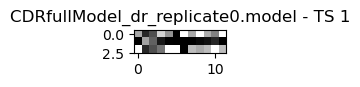

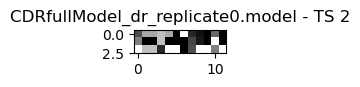

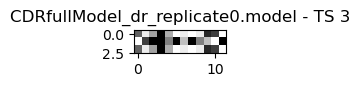

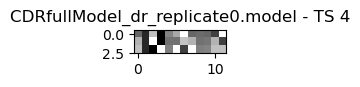

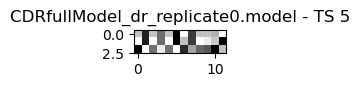

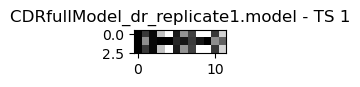

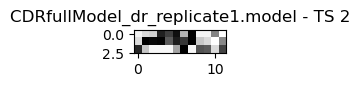

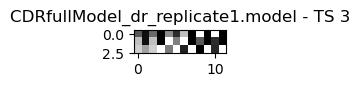

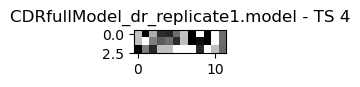

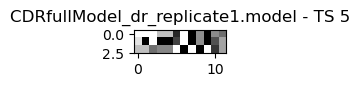

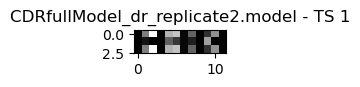

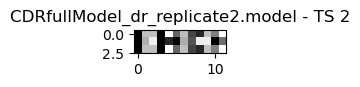

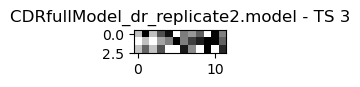

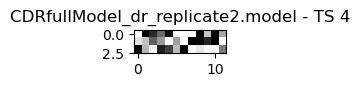

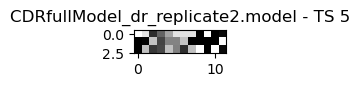

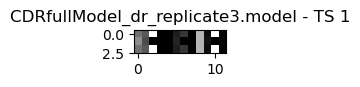

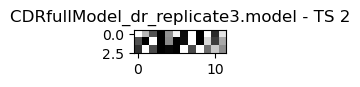

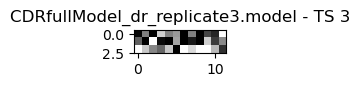

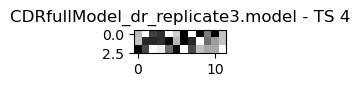

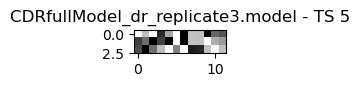

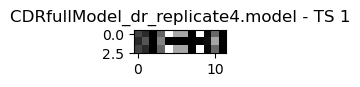

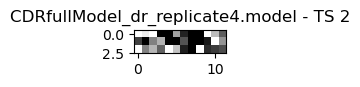

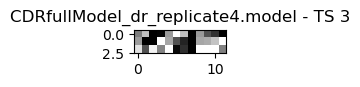

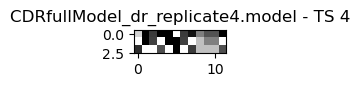

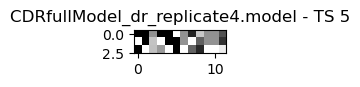

In [17]:
for key, model in cdrmodels.items():
    for ts in [1,2,3,4,5]:
        S,H=shrinkingDecompositionInformation(model,12,nX,nW.transpose(),whichTS=ts)
        figure(figsize=[1.2,0.3])
        imshow(removalIntoMatrix(S,12,H),cmap='gray')
        title(f"{key} - TS {ts}")

C:\Users\enajasa\AppData\Local\Temp\ipykernel_24292\3341042127.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=[1.2,0.3])


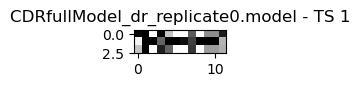

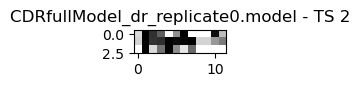

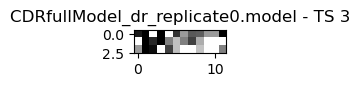

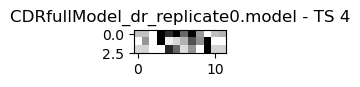

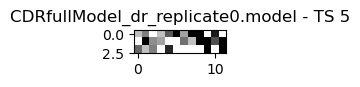

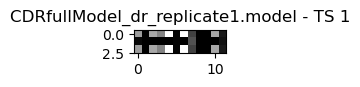

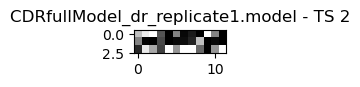

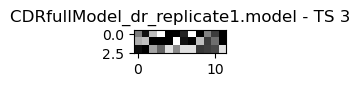

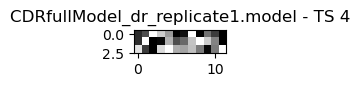

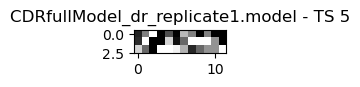

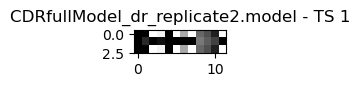

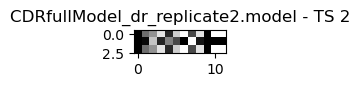

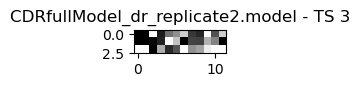

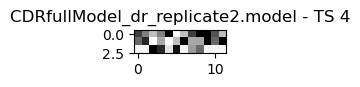

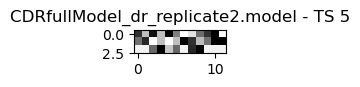

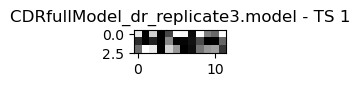

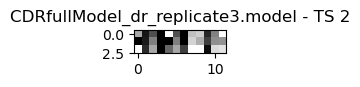

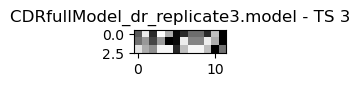

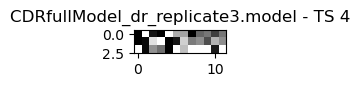

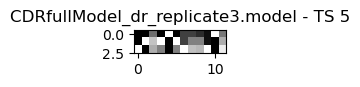

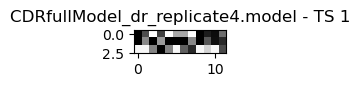

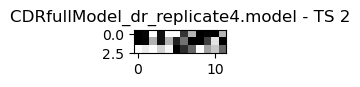

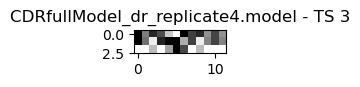

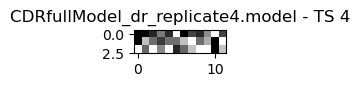

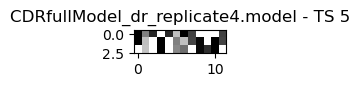

In [24]:
nX,nY,nS,nW=makeNoisyDataset(X,Y,8,0.1)
images=[]
for key, model in cdrmodels.items():
    for ts in [1,2,3,4,5]:
        S,H=shrinkingDecompositionInformation(model,12,nX,nW.transpose(),whichTS=ts)
        figure(figsize=[1.2,0.3])
        I=removalIntoMatrix(S,12,H)
        imshow(I,cmap="gray")
        #title(str(ts))
        title(f"{key} - TS {ts}")
        images.append(I.flatten())

# Correlation Coefficient Calculation

In [18]:
import numpy as np
from matplotlib.pyplot import figure, imshow, title

SEED = 42  # Choose any seed value
np.random.seed(SEED)

nX, nY, nS, nW = makeNoisyDataset(X, Y, 8, 0.1)

# Initialize a list to store correlation coefficients for all models
all_corr_coefs = []

# Loop through all the models in `cdrmodels`
for key, model in cdrmodels.items():
    print(f"Processing model: {key}")

    # Initialize a list to store the images for the current model
    images = []

    # Loop through the time steps 1 to 5
    for ts in [1, 2, 3, 4, 5]:
        S, H = shrinkingDecompositionInformation(model, 12, nX, nW.transpose(), whichTS=ts)
        I = removalIntoMatrix(S, 12, H)
        images.append(I.flatten())

    # Loop through pairs of images, calculate their correlation coefficients, and print the results
    for i in range(len(images) - 1):
        for j in range(i + 1, len(images)):
            corr_coef = np.corrcoef(images[i], images[j])[0, 1]
            all_corr_coefs.append(abs(corr_coef))
            print(f"Model: {key} | Comparing images {i + 1} and {j + 1}: {corr_coef}")

# Calculate the overall mean correlation coefficient directly from all correlation coefficients
overall_mean_corr_coef = np.mean(all_corr_coefs)
print(f"Overall mean correlation coefficient: {overall_mean_corr_coef}")


Processing model: CDRfullModel_dr_replicate0.model
Model: CDRfullModel_dr_replicate0.model | Comparing images 1 and 2: 0.5277565336910092
Model: CDRfullModel_dr_replicate0.model | Comparing images 1 and 3: 0.257384777043168
Model: CDRfullModel_dr_replicate0.model | Comparing images 1 and 4: 0.22894967879534145
Model: CDRfullModel_dr_replicate0.model | Comparing images 1 and 5: 0.13555812721681618
Model: CDRfullModel_dr_replicate0.model | Comparing images 2 and 3: 0.29071610451057933
Model: CDRfullModel_dr_replicate0.model | Comparing images 2 and 4: 0.05477828273189762
Model: CDRfullModel_dr_replicate0.model | Comparing images 2 and 5: 0.18155190514559333
Model: CDRfullModel_dr_replicate0.model | Comparing images 3 and 4: 0.23386668952949843
Model: CDRfullModel_dr_replicate0.model | Comparing images 3 and 5: 0.28347218506328553
Model: CDRfullModel_dr_replicate0.model | Comparing images 4 and 5: 0.4934632625148887
Processing model: CDRfullModel_dr_replicate1.model
Model: CDRfullModel_dr

In [24]:
len(images)

5

# Euclidean Distance Calculation

In [19]:
import numpy as np
from matplotlib.pyplot import figure, imshow, title

SEED = 42  # Choose any seed value
np.random.seed(SEED)

nX, nY, nS, nW = makeNoisyDataset(X, Y, 8, 0.1)

# Initialize a list to store Euclidean distances for all models
all_euclidean_dists = []

# Loop through all the models in `cdrmodels`
for key, model in cdrmodels.items():
    print(f"Processing model: {key}")

    # Initialize a list to store the images for the current model
    images = []

    # Loop through the time steps 1 to 5
    for ts in [1, 2, 3, 4, 5]:
        S, H = shrinkingDecompositionInformation(model, 12, nX, nW.transpose(), whichTS=ts)
        I = removalIntoMatrix(S, 12, H)
        images.append(I.flatten())

    # Loop through pairs of images, calculate their Euclidean distances, and print the results
    for i in range(len(images) - 1):
        for j in range(i + 1, len(images)):
            euclidean_dist = np.linalg.norm(images[i] - images[j])
            all_euclidean_dists.append(euclidean_dist)
            print(f"Model: {key} | Comparing images {i + 1} and {j + 1}: {euclidean_dist}")

# Calculate the overall mean Euclidean distance directly from all Euclidean distances
overall_mean_euclidean_dist = np.mean(all_euclidean_dists)
print(f"Overall mean Euclidean distance: {overall_mean_euclidean_dist}")



Processing model: CDRfullModel_dr_replicate0.model
Model: CDRfullModel_dr_replicate0.model | Comparing images 1 and 2: 2.231477358642105
Model: CDRfullModel_dr_replicate0.model | Comparing images 1 and 3: 2.715418443767478
Model: CDRfullModel_dr_replicate0.model | Comparing images 1 and 4: 2.4279218889662366
Model: CDRfullModel_dr_replicate0.model | Comparing images 1 and 5: 2.7272447179632926
Model: CDRfullModel_dr_replicate0.model | Comparing images 2 and 3: 2.844815305913016
Model: CDRfullModel_dr_replicate0.model | Comparing images 2 and 4: 2.95644650603054
Model: CDRfullModel_dr_replicate0.model | Comparing images 2 and 5: 2.8937409613242484
Model: CDRfullModel_dr_replicate0.model | Comparing images 3 and 4: 2.5865258948547747
Model: CDRfullModel_dr_replicate0.model | Comparing images 3 and 5: 2.6279185244217973
Model: CDRfullModel_dr_replicate0.model | Comparing images 4 and 5: 1.9510152107026457
Processing model: CDRfullModel_dr_replicate1.model
Model: CDRfullModel_dr_replicate1

In [21]:
import numpy as np
from matplotlib.pyplot import figure, imshow, title

SEED = 42  # Choose any seed value
np.random.seed(SEED)

nX, nY, nS, nW = makeNoisyDataset(X, Y, 8, 0.1)

# Initialize a list to store Euclidean distances for all models
all_euclidean_dists = []

# Loop through all the models in `cdrmodels`
for key, model in cdrmodels.items():
    print(f"Processing model: {key}")

    # Initialize a list to store the images for the current model
    images = []

    # Loop through the time steps 1 to 5
    for ts in [1, 2, 3, 4, 5]:
        S, H = shrinkingDecompositionInformation(model, 12, nX, nW.transpose(), whichTS=ts)
        I = removalIntoMatrix(S, 12, H)
        images.append(I.flatten())

    # Loop through pairs of images, calculate their Euclidean distances, and print the results
    for i in range(len(images) - 1):
        for j in range(i + 1, len(images)):
            diff = images[i] - images[j]
            euclidean_dist = np.sqrt(np.dot(diff, diff.T))
            all_euclidean_dists.append(euclidean_dist)
            print(f"Model: {key} | Comparing images {i + 1} and {j + 1}: {euclidean_dist}")

# Calculate the overall mean Euclidean distance directly from all Euclidean distances
overall_mean_euclidean_dist = np.mean(all_euclidean_dists)
print(f"Overall mean Euclidean distance: {overall_mean_euclidean_dist}")


Processing model: CDRfullModel_dr_replicate0.model
Model: CDRfullModel_dr_replicate0.model | Comparing images 1 and 2: 2.231477358642105
Model: CDRfullModel_dr_replicate0.model | Comparing images 1 and 3: 2.715418443767478
Model: CDRfullModel_dr_replicate0.model | Comparing images 1 and 4: 2.4279218889662366
Model: CDRfullModel_dr_replicate0.model | Comparing images 1 and 5: 2.7272447179632926
Model: CDRfullModel_dr_replicate0.model | Comparing images 2 and 3: 2.844815305913016
Model: CDRfullModel_dr_replicate0.model | Comparing images 2 and 4: 2.95644650603054
Model: CDRfullModel_dr_replicate0.model | Comparing images 2 and 5: 2.8937409613242484
Model: CDRfullModel_dr_replicate0.model | Comparing images 3 and 4: 2.5865258948547747
Model: CDRfullModel_dr_replicate0.model | Comparing images 3 and 5: 2.6279185244217973
Model: CDRfullModel_dr_replicate0.model | Comparing images 4 and 5: 1.9510152107026457
Processing model: CDRfullModel_dr_replicate1.model
Model: CDRfullModel_dr_replicate1

In [22]:
import numpy as np
from matplotlib.pyplot import figure, imshow, title

SEED = 42  # Choose any seed value
np.random.seed(SEED)

nX, nY, nS, nW = makeNoisyDataset(X, Y, 8, 0.1)

# Initialize a list to store Euclidean distances for all models
all_euclidean_dists = []

# Loop through all the models in `cdrmodels`
for key, model in cdrmodels.items():
    print(f"Processing model: {key}")

    # Initialize a list to store the images for the current model
    images = []

    # Loop through the time steps 1 to 5
    for ts in [1, 2, 3, 4, 5]:
        S, H = shrinkingDecompositionInformation(model, 12, nX, nW.transpose(), whichTS=ts)
        I = removalIntoMatrix(S, 12, H)
        images.append(I.flatten())

    # Loop through pairs of images, calculate their Euclidean distances, and print the results
    for i in range(len(images) - 1):
        for j in range(i + 1, len(images)):
            diff = images[i] - images[j]
            euclidean_dist = np.sqrt(np.sum(np.square(diff)))
            all_euclidean_dists.append(euclidean_dist)
            print(f"Model: {key} | Comparing images {i + 1} and {j + 1}: {euclidean_dist}")

# Calculate the overall mean Euclidean distance directly from all Euclidean distances
overall_mean_euclidean_dist = np.mean(all_euclidean_dists)
print(f"Overall mean Euclidean distance: {overall_mean_euclidean_dist}")


Processing model: CDRfullModel_dr_replicate0.model
Model: CDRfullModel_dr_replicate0.model | Comparing images 1 and 2: 2.231477358642105
Model: CDRfullModel_dr_replicate0.model | Comparing images 1 and 3: 2.715418443767478
Model: CDRfullModel_dr_replicate0.model | Comparing images 1 and 4: 2.427921888966236
Model: CDRfullModel_dr_replicate0.model | Comparing images 1 and 5: 2.7272447179632926
Model: CDRfullModel_dr_replicate0.model | Comparing images 2 and 3: 2.844815305913016
Model: CDRfullModel_dr_replicate0.model | Comparing images 2 and 4: 2.95644650603054
Model: CDRfullModel_dr_replicate0.model | Comparing images 2 and 5: 2.8937409613242484
Model: CDRfullModel_dr_replicate0.model | Comparing images 3 and 4: 2.5865258948547747
Model: CDRfullModel_dr_replicate0.model | Comparing images 3 and 5: 2.6279185244217973
Model: CDRfullModel_dr_replicate0.model | Comparing images 4 and 5: 1.9510152107026457
Processing model: CDRfullModel_dr_replicate1.model
Model: CDRfullModel_dr_replicate1.